# 원티드 프리온보딩 3주차 - 모두의 주차장

### 디지털 스킬셋 기술과제

주제
- 	앱 이용자 별 향후 이용 건수 예측

Value chain상 정의
- 이용자 별 향후 이용 건수를 예측하여 마케팅, 영업 등의 의사 결정 과정에 활용

모델 개발 요건
- 이용자 별 결제 이력을 바탕으로 한 향후 한 달간 이용 건수 예측

### Data 정의

Input: Tabular 데이터
- 	2020.01.01 ~ 2020.12-31 

Output: Regression (향후 이용 건수 예측)

Task 정의
- 	Regression, 유저 별 한 달 후 이용 건수 예측

Metric 정의
- 	MSE, MAE

데이터 수집
- 유저 가입 정보: id, 가입일
- 소비 행동 정보: 상품id, 점포 주소, 결제일, 결제건수
- 외부 정보: 서울시 지점별 교통량 데이터 기온, 강수량, 풍속 등 기상데이터



In [295]:
!pip install pycaret

라이브러리 임포트

In [296]:
!apt -qq -y install fonts-nanum > /dev/null

지정된 경로를 찾을 수 없습니다.


In [297]:
### 라이브러리 임포트
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 경고창 무시
import warnings
warnings.filterwarnings(action='ignore')

# matplotlib 한글 폰트 오류 해결
import platform
from matplotlib import rc
import matplotlib.font_manager as fm
import matplotlib as mpl



plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='appleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = fm.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
    font = fm.FontProperties(fname=fontpath, size=10)
    fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

데이터 불러오기

In [298]:
### 데이터 불러오기
# C:\Users\Bonghwan\Downloads\week3\modu
df = pd.read_csv('C:/Users/Bonghwan/Downloads/week3/modu/실전db.csv')
traffic = pd.read_excel('C:/Users/Bonghwan/Downloads/week3/modu/2020교통량통합.xlsx')
weather = pd.read_csv('C:/Users/Bonghwan/Downloads/week3/modu/서울시_기상데이터.csv', encoding='cp949')

df.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     879271 non-null  int64 
 1   JOIN_DATE   879271 non-null  object
 2   D_TYPE      879271 non-null  object
 3   STORE_ID    879271 non-null  int64 
 4   GOODS_TYPE  879271 non-null  object
 5   DATE        879271 non-null  object
 6   COUNT       879271 non-null  int64 
 7   AD1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


### 각 데이터 확인

- 유저 정보
1. USER_ID : 유저별 ID 
2. JOIN_DATE : 유저별 가입일

- 결제 정보
1. D_TYPE :
2. STORE_ID : 점포별 ID
3. GOODS_TYPE : 상품 타입(주차권 종류)
4. COUNT : 결제건수 ( LABEL )
5. AD1 : 주소

- 추가 정보
1. 서울시 지점별 교통량 데이터
2. 기상데이터



In [300]:
##컬럼별 데이터 확인
len(df['USER_ID'].unique()) # USER_ID : 165425 개
type(df['JOIN_DATE'].unique()[0]) # 가입일 : str

type(df['D_TYPE'][0]) # d_type : AA, BB, CC 그룹 분류, str
len(df['STORE_ID'].unique()) ## 1061 점포 갯수
df['GOODS_TYPE'].unique() ## 상품 타입(?) A, B, C, D 그룹 분류, str
type(df['DATE'][0]) # 날짜 : str
len(df['COUNT'].unique()) ## count : 61 개
len(df['AD1'].unique()) ## 85개

# np.random.seed(42)

85

DATE & JOIN_DATE 데이터 타입 변경

In [301]:
from datetime import datetime
df['DATE']=df['DATE'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
df['JOIN_DATE']=df['JOIN_DATE'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))

In [302]:
df['day']=df['DATE'].dt.dayofweek
df['month']=df['DATE'].dt.month
df['week']=df['DATE'].dt.week

### 고객 등급
- 고객별 결제 건수를 통해 고객 등급을 나눔

In [377]:
user_count_sum = df.groupby('USER_ID')['COUNT'].sum().reset_index().sort_values('COUNT', ascending = False)

In [381]:
user_count_sum['COUNT'].describe()

count    165425.000000
mean          5.469784
std          22.823610
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        7919.000000
Name: COUNT, dtype: float64

In [379]:
# 처음 이용 고객(COUNT=1)
new_user = user_count_sum.loc[user_count_sum['COUNT']==1].count()
new_user

USER_ID    73947
COUNT      73947
dtype: int64

In [383]:
# 실버고객(COUNT=2~4)
silver_user = user_count_sum.loc[user_count_sum['COUNT']>1]
silver_user.describe()

,USER_ID,COUNT
count,9.147800e+04,91478.000000
mean,1.220464e+06,9.082971
std,4.322625e+05,30.212644
min,2.240000e+02,2.000000
25%,9.040532e+05,2.000000
50%,1.343640e+06,4.000000
75%,1.571649e+06,9.000000
max,1.830491e+06,7919.000000


In [384]:
# 골드고객(COUNT=5~18)
gold_user = user_count_sum.loc[user_count_sum['COUNT']>=5]
gold_user.describe()

,USER_ID,COUNT
count,4.084900e+04,40849.000000
mean,1.202377e+06,17.051360
std,4.259325e+05,43.917121
min,2.320000e+02,5.000000
25%,8.884810e+05,6.000000
50%,1.316468e+06,10.000000
75%,1.548143e+06,18.000000
max,1.826434e+06,7919.000000


In [385]:
# VIP고객(COUNT=19~47)
vip_user = user_count_sum.loc[user_count_sum['COUNT']>=18]
vip_user.describe()

,USER_ID,COUNT
count,1.076200e+04,10762.000000
mean,1.198506e+06,40.742241
std,4.104179e+05,80.789425
min,2.320000e+02,18.000000
25%,9.030650e+05,22.000000
50%,1.314580e+06,30.000000
75%,1.527769e+06,47.000000
max,1.811081e+06,7919.000000


In [386]:
# VVIP고객(COUNT=48~90)
vvip_user = user_count_sum.loc[user_count_sum['COUNT']>=48]
vvip_user.describe()

,USER_ID,COUNT
count,2.605000e+03,2605.000000
mean,1.171384e+06,81.368138
std,3.977281e+05,156.802573
min,7.973000e+03,48.000000
25%,8.798010e+05,56.000000
50%,1.281026e+06,68.000000
75%,1.508428e+06,90.000000
max,1.739610e+06,7919.000000


In [387]:
# MVP고객(COUNT=91~)
mvp_user = user_count_sum.loc[user_count_sum['COUNT']>=91]
mvp_user.describe()

,USER_ID,COUNT
count,6.510000e+02,651.000000
mean,1.127322e+06,134.855607
std,3.798447e+05,307.027291
min,3.088200e+04,91.000000
25%,8.503255e+05,99.000000
50%,1.211118e+06,115.000000
75%,1.482670e+06,138.000000
max,1.690069e+06,7919.000000


총 165,424 유저 중

- new = 73947명
- silver = 50629명
- gold = 30087명
- vip = 8157명
- vvip = 1954명
- mvp = 650명

In [388]:
# 고객 등급 컬럼 생성
grade_list = []

for c in user_count_sum['COUNT']:
    if c == 1:
        grade_list.append('new')
    elif 2 <= c < 5:
        grade_list.append('silver')
    elif 5 <= c < 19:
        grade_list.append('gold')
    elif 19 <= c < 48:
        grade_list.append('vip')
    elif 48 <= c < 91:
        grade_list.append('vvip')
    elif c >= 91:
        grade_list.append('mvp')
    else:
        print('not_our_customer')
        
user_count_sum['GRADE'] = grade_list

In [389]:
user_count_sum.loc[user_count_sum['GRADE']=='vvip'].sort_values('COUNT',ascending=False)

,USER_ID,COUNT,GRADE
98832,1506437,90,vvip
68867,1286164,90,vvip
120713,1595426,90,vvip
86508,1444258,90,vvip
25983,743044,90,vvip
...,...,...,...
46231,1030767,48,vvip
128236,1625197,48,vvip
93610,1483357,48,vvip
99032,1507281,48,vvip


In [390]:
user_count_sum = user_count_sum.rename({'COUNT':'COUNT_SUM'}, axis=1)
user_count_sum

,USER_ID,COUNT_SUM,GRADE
44115,999665,7919,mvp
100781,1514190,284,mvp
16448,591610,245,mvp
90227,1467323,239,mvp
76230,1355841,235,mvp
...,...,...,...
45671,1023974,1,new
110166,1551355,1,new
45674,1024027,1,new
45676,1024047,1,new


In [391]:
# 주 데이터에 유저ID별_결제건수_합과 고객등급에 관한 컬럼 merge
df = pd.merge(df, user_count_sum, how='left', on='USER_ID')
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week,is_weekend,is_holiday,DAY,COUNT_SUM,GRADE
0,999665,2018-12-16,CC,96266,A,2020-11-07,61,GN,5,11,45,1,0,5,7919,mvp
1,999665,2018-12-16,CC,109677,A,2020-11-13,59,JRR,4,11,46,0,0,4,7919,mvp
2,999665,2018-12-16,CC,1109,A,2020-11-14,58,JRR,5,11,46,1,0,5,7919,mvp
3,999665,2018-12-16,CC,190055,A,2020-11-06,55,SB,4,11,45,0,0,4,7919,mvp
4,999665,2018-12-16,CC,131081,A,2020-11-19,53,YO,3,11,47,0,0,3,7919,mvp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1579165,2020-05-26,AA,27996,A,2020-05-27,1,J,2,5,22,0,0,2,47,vip
879267,1579168,2020-05-26,AA,104916,A,2020-05-27,1,GN,2,5,22,0,0,2,1,new
879268,1579173,2020-05-26,AA,93362,A,2020-05-27,1,CY,2,5,22,0,0,2,44,vip
879269,1579174,2020-05-26,BB,221017,A,2020-05-27,1,YD,2,5,22,0,0,2,7,gold


In [392]:
df.groupby('D_TYPE')['COUNT'].value_counts()

D_TYPE  COUNT
AA      1        484275
        2          7801
        3           726
        4           183
        5            83
                  ...  
CC      53            1
        55            1
        58            1
        59            1
        61            1
Name: COUNT, Length: 88, dtype: int64

In [393]:
## 가입일에 따른 유저수 파악
df.groupby('JOIN_DATE')['USER_ID'].value_counts()

JOIN_DATE   USER_ID
1970-01-01  654237     67
            1355917    52
            1477219    50
            1251357    41
            1163314    39
                       ..
2020-12-31  1830551     1
            1830570     1
            1830580     1
            1830589     1
            1830598     1
Name: USER_ID, Length: 165425, dtype: int64

In [411]:
len(df[df['JOIN_DATE']<'1971']['USER_ID'].unique())
len(df.query('JOIN_DATE < 2000')['USER_ID'].unique())
len(df.USER_ID.unique())
len(df.JOIN_DATE.unique())

264

USER_ID 별 JOIN_DATE 

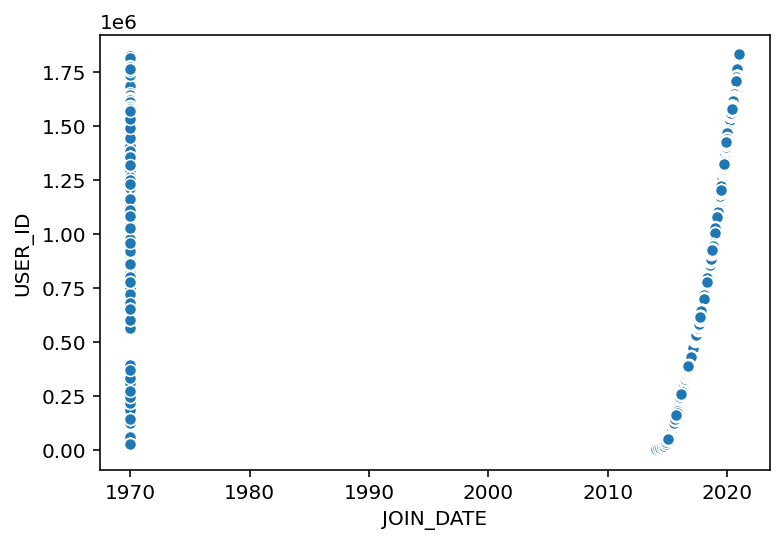

In [412]:
sns.scatterplot(data=df, x='JOIN_DATE', y = 'USER_ID')

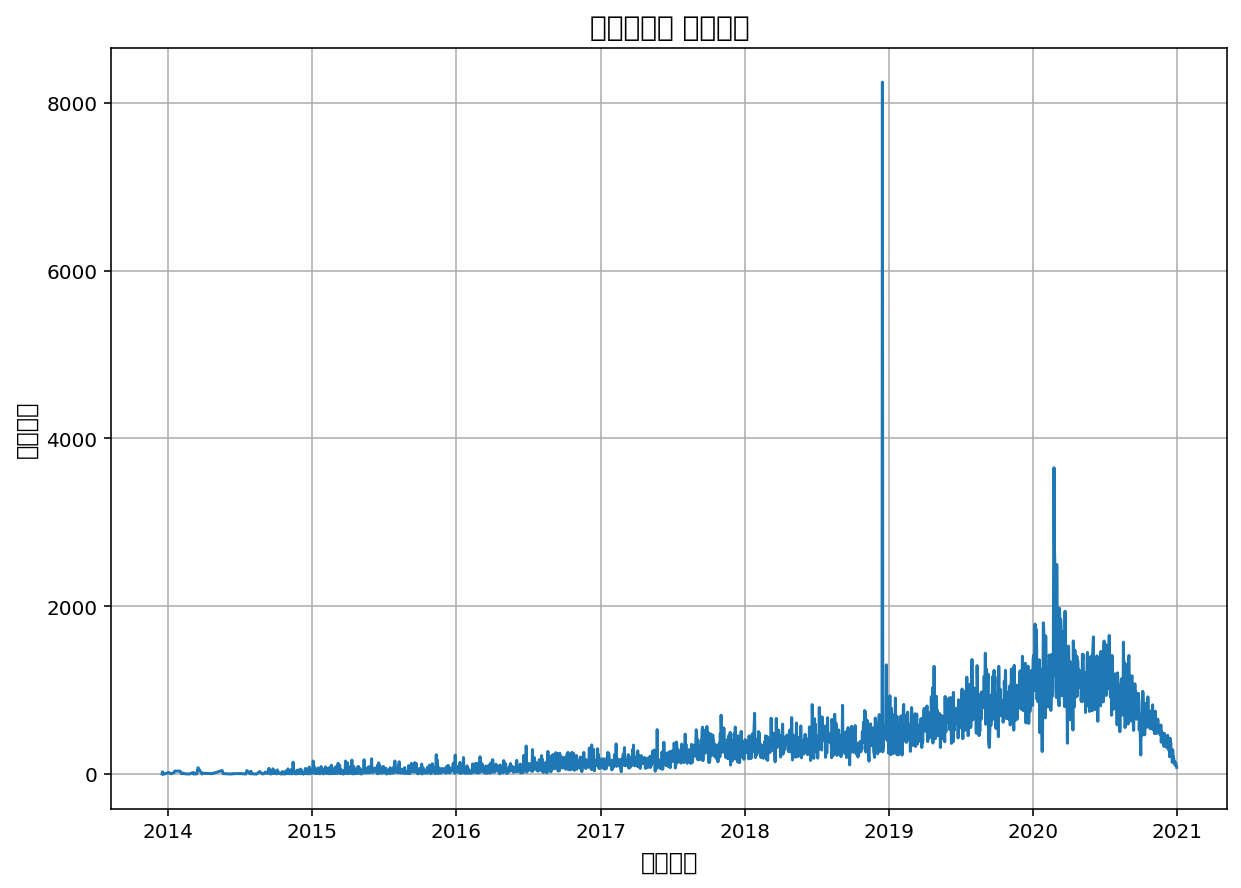

In [444]:
# JOIN_DATE별 COUNT값(가입일 미상인 데이터는 제외) - 그래프를 위해
abn_list =df[df['JOIN_DATE'] < '1971']['USER_ID'].tolist()
normal_joindate_df = df[~df['USER_ID'].isin(abn_list)]

plt.figure(figsize=(10,7))
sns.lineplot(normal_joindate_df.groupby("JOIN_DATE")["COUNT"].sum().keys(),normal_joindate_df.groupby("JOIN_DATE")["COUNT"].sum())
plt.title('가입년도별 결제건수', fontsize=14)
plt.ylabel('결제건수', fontsize=12)
plt.xlabel('가입년도', fontsize=12)
plt.grid()
plt.show()

USER_ID는 JOIN_DATE가 1970년에 집중적, 그리고 2010년 중반 이후에 분포


- 이상치로 처리하지 않은 이유
1. 가입일이 1970-01-01인 데이터는 결제일이 2020년에 집계되므로 가입일을 알 수 없는 고객 데이터일 것으로 추정
2. 결제건수로 향후 이용 건수를 예측한다면 가입일 미상인 데이터도 활용할 수 있을 것


In [414]:
df.groupby(["USER_ID", "D_TYPE"])['JOIN_DATE'].count()

USER_ID  D_TYPE
224      AA         2
232      BB        23
342      AA         1
565      AA         2
729      AA         1
                   ..
1830551  BB         1
1830570  BB         1
1830580  AA         1
1830589  BB         1
1830598  AA         1
Name: JOIN_DATE, Length: 165425, dtype: int64

In [310]:
## USER_ID 별 D_TYPE이 다른지 확인
from tqdm import tqdm

id_list = df["USER_ID"].unique().tolist()
for i in tqdm(id_list):
  # print(df[df['USER_ID']==i]["D_TYPE"])
  ch_list = df[df['USER_ID']==i]["D_TYPE"].tolist()
  for c in ch_list:
    
    if ch_list.count(c) != len(ch_list):
      # print(ch_list.count(c), len(ch_list))
      print('{}의 D_TYPE이 다름'.format(i))
    

100%|████████████████████████████████████████████████████████████████████████| 165425/165425 [02:43<00:00, 1009.77it/s]


### USER_ID별 D_TYPE은 동일한 것으로 보아, D_TYPE은 유저별 고정값으로 볼 수 있음


In [311]:
ndf_list

[        USER_ID  JOIN_DATE D_TYPE  STORE_ID GOODS_TYPE       DATE  COUNT AD1
 0          2858 2014-01-07     AA      1892          A 2020-01-01      1  GN
 9         73825 2015-04-07     BB      1900          C 2020-01-01      1  GN
 16       118732 2015-07-03     AA    220690          C 2020-01-01      1  GN
 22       151196 2015-09-02     AA     90542          A 2020-01-01      1  GN
 30       269477 2016-03-20     AA      2457          C 2020-01-01      1  GN
 ...         ...        ...    ...       ...        ...        ...    ...  ..
 879257  1830390 2020-12-31     BB    221013          B 2020-12-31      1  GN
 879258  1830405 2020-12-31     AA    220848          B 2020-12-31      1  GN
 879262  1830477 2020-12-31     AA       472          B 2020-12-31      1  GN
 879263  1830491 2020-12-31     BB    220284          B 2020-12-31      2  GN
 879266  1830551 2020-12-31     BB    219886          B 2020-12-31      1  GN
 
 [172967 rows x 8 columns],
         USER_ID  JOIN_DATE D_TYPE

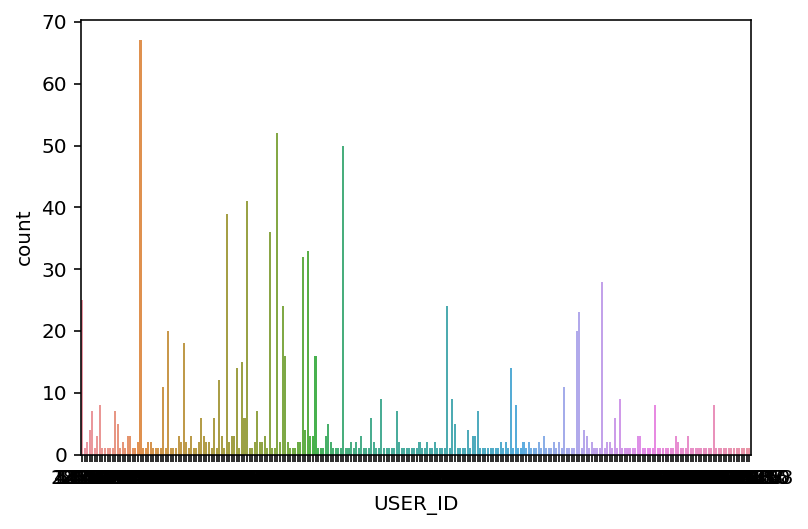

In [312]:
sns.countplot(data=df[df["JOIN_DATE"]=='1970'], x='USER_ID')

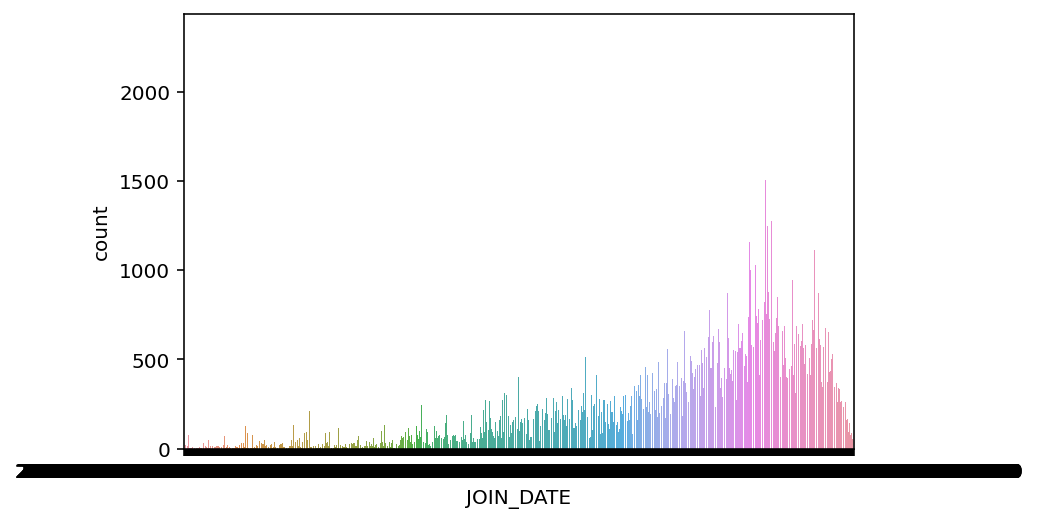

In [314]:
sns.countplot(data=df.query('D_TYPE=="AA"'), x='JOIN_DATE')

In [315]:
df[df['COUNT']==cdf['COUNT'].max()]
df[df['D_TYPE']=='AA']['COUNT'].max() # 23
df[df['D_TYPE']=='AA']['COUNT'].min() # 1
df[df['D_TYPE']=='BB']['COUNT'].max() # 19
df[df['D_TYPE']=='BB']['COUNT'].min() # 1
df[df['D_TYPE']=='CC']['COUNT'].max() # 61
df[df['D_TYPE']=='CC']['COUNT'].min() # 1

1

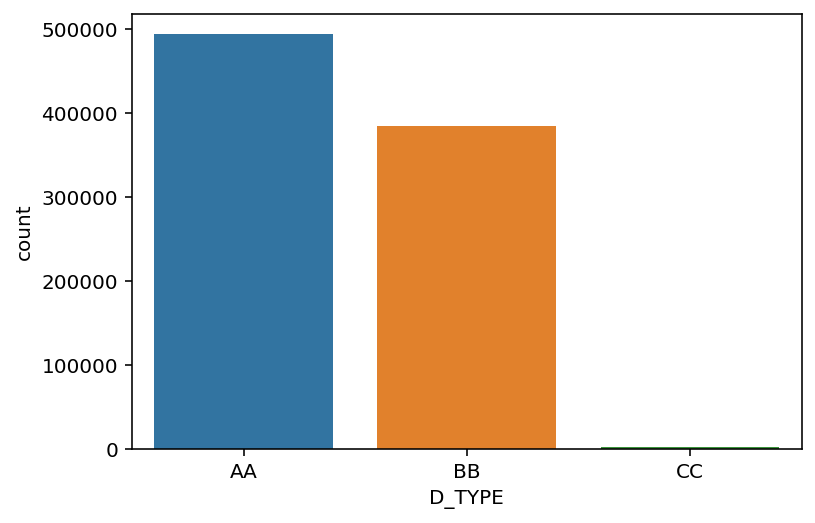

In [316]:
sns.countplot(data=df, x='D_TYPE')

### D_TYPE은 
1. AA 그룹에서 1~23
2. BB 그룹에서 1~19
3. CC 그룹에서 1~61
의 범위를 가짐

C 그룹의 결제건수가 확연히 적음

In [317]:
adf = df.query("D_TYPE == 'AA'")
bdf = df.query("D_TYPE == 'BB'")
cdf = df.query("D_TYPE == 'CC'")

In [318]:
adf.query('GOODS_TYPE == "A"') # 345779 
adf.query('GOODS_TYPE == "B"') #  65966
adf.query('GOODS_TYPE == "C"') #  70010

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2,1,1
14,88589,2015-05-18,AA,2334,C,2020-01-01,1,MP,2,1,1
16,118732,2015-07-03,AA,220690,C,2020-01-01,1,GN,2,1,1
20,138118,2015-08-09,AA,102276,C,2020-01-01,1,SC,2,1,1
25,175466,2015-10-10,AA,82408,C,2020-01-01,1,GSN,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...
879213,1829862,2020-12-31,AA,109877,C,2020-12-31,1,GN,3,12,53
879226,1829935,2020-12-31,AA,220893,C,2020-12-31,1,J,3,12,53
879231,1829962,2020-12-31,AA,220689,C,2020-12-31,1,GN,3,12,53
879236,1830033,2020-12-31,AA,109050,C,2020-12-31,1,GJ,3,12,53


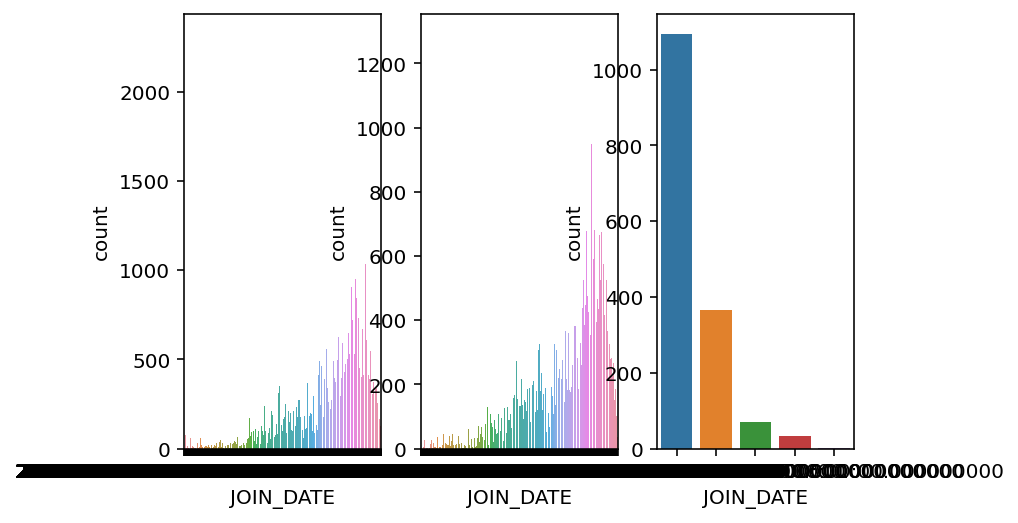

In [319]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1)
sns.countplot(data=adf, x='JOIN_DATE', ax=ax1)
sns.countplot(data=bdf, x='JOIN_DATE', ax=ax2)
sns.countplot(data=cdf, x='JOIN_DATE', ax=ax3)

D_TYPE이 CC 인 경우 JOIN_DATE가 특정일에 몰려있는 것을 볼 수 있음 
-> D_TYPE이 될 수 있는 데이터 가정
1. Driver_Type
2. 가입경로(개인, 소셜, 기업)
3. 결제수단


In [320]:
adf.describe()

,USER_ID,STORE_ID,COUNT,day,month,week
count,4.931660e+05,493166.000000,493166.000000,493166.000000,493166.000000,493166.000000
mean,1.219591e+06,149413.979623,1.021920,2.865410,6.975572,29.003654
std,4.139052e+05,68951.682792,0.197749,1.912934,3.347686,14.647331
min,2.240000e+02,4.000000,1.000000,0.000000,1.000000,1.000000
25%,9.298790e+05,92305.000000,1.000000,1.000000,4.000000,17.000000
50%,1.338080e+06,172934.000000,1.000000,3.000000,7.000000,30.000000
75%,1.542206e+06,220661.000000,1.000000,4.000000,10.000000,42.000000
max,1.830598e+06,231465.000000,23.000000,6.000000,12.000000,53.000000


In [321]:
bdf.describe()

,USER_ID,STORE_ID,COUNT,day,month,week
count,3.845410e+05,384541.000000,384541.000000,384541.000000,384541.000000,384541.000000
mean,1.189914e+06,149854.344278,1.018617,2.873649,7.018695,29.185551
std,4.287848e+05,68840.134196,0.172946,1.917025,3.327902,14.554846
min,2.320000e+02,4.000000,1.000000,0.000000,1.000000,1.000000
25%,8.638920e+05,92437.000000,1.000000,1.000000,4.000000,17.000000
50%,1.297911e+06,173176.000000,1.000000,3.000000,7.000000,30.000000
75%,1.542989e+06,220661.000000,1.000000,4.000000,10.000000,42.000000
max,1.830589e+06,231465.000000,19.000000,6.000000,12.000000,53.000000


In [322]:
cdf.describe()

,USER_ID,STORE_ID,COUNT,day,month,week
count,1.564000e+03,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000
mean,1.193629e+06,145698.795396,5.858696,2.843990,5.689258,23.342711
std,3.641901e+05,65876.144630,10.229165,1.882324,3.215941,13.953591
min,2.829200e+04,635.000000,1.000000,0.000000,1.000000,1.000000
25%,9.996650e+05,92437.000000,1.000000,1.000000,3.000000,12.000000
50%,1.247912e+06,131081.000000,1.000000,3.000000,5.000000,22.000000
75%,1.477219e+06,220655.000000,2.000000,4.000000,8.000000,34.000000
max,1.829458e+06,231060.000000,61.000000,6.000000,12.000000,53.000000


- D_TYPE   
AA와 BB는 평균이나 표준 편차, MAX값에서도 큰 차이가 없음.  
CC의 경우 MAX값이나 표준 편차 평균에서도 큰 차이를 보임. 다만 표본 자체가 적은편

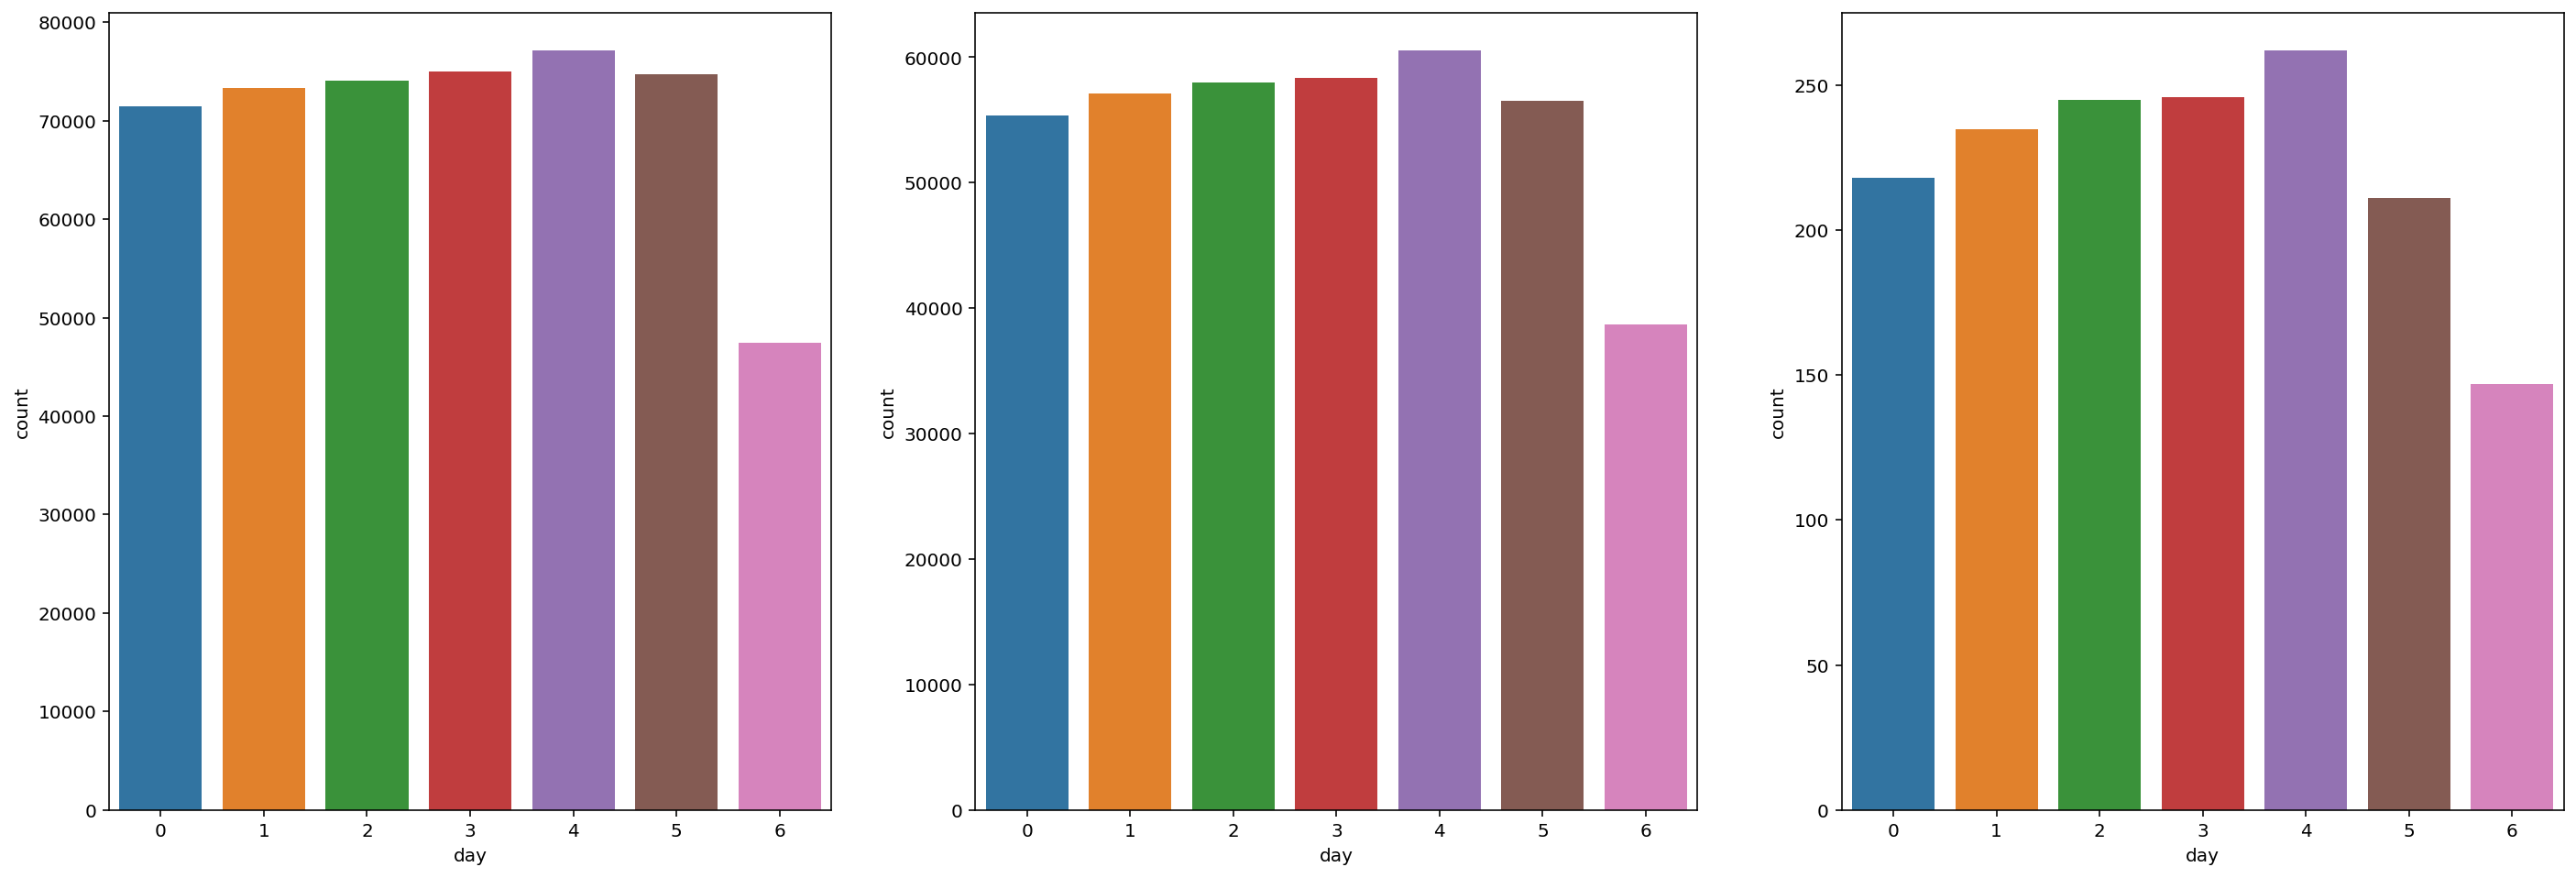

In [323]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(24, 8)
sns.countplot(data=df.query('D_TYPE == "AA"'), x="day", ax=ax1)
sns.countplot(data=df.query('D_TYPE == "BB"'), x="day", ax=ax2)
sns.countplot(data=df.query('D_TYPE == "CC"'), x="day", ax=ax3)

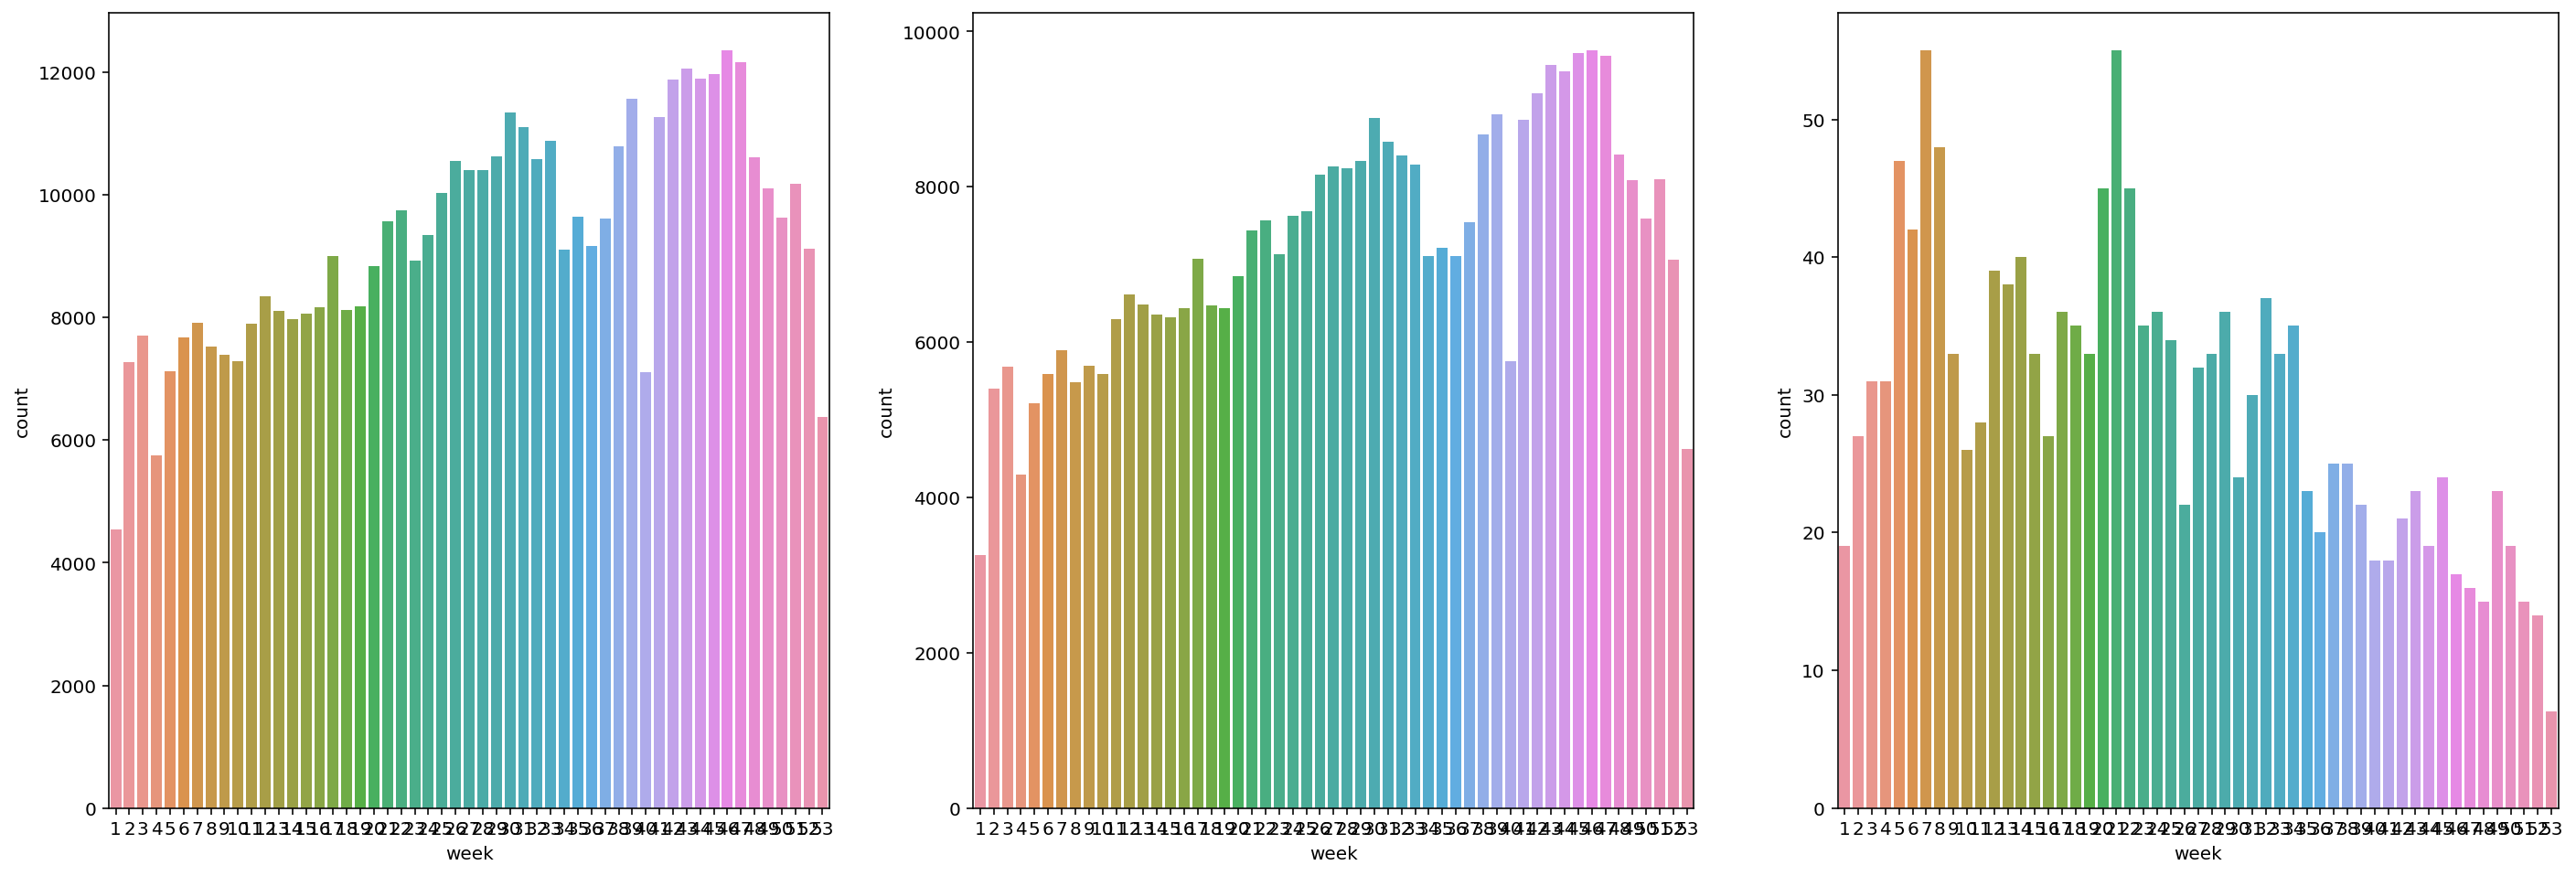

In [324]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(24, 8)
sns.countplot(data=df.query('D_TYPE == "AA"'), x="week", ax=ax1)
sns.countplot(data=df.query('D_TYPE == "BB"'), x="week", ax=ax2)
sns.countplot(data=df.query('D_TYPE == "CC"'), x="week", ax=ax3)


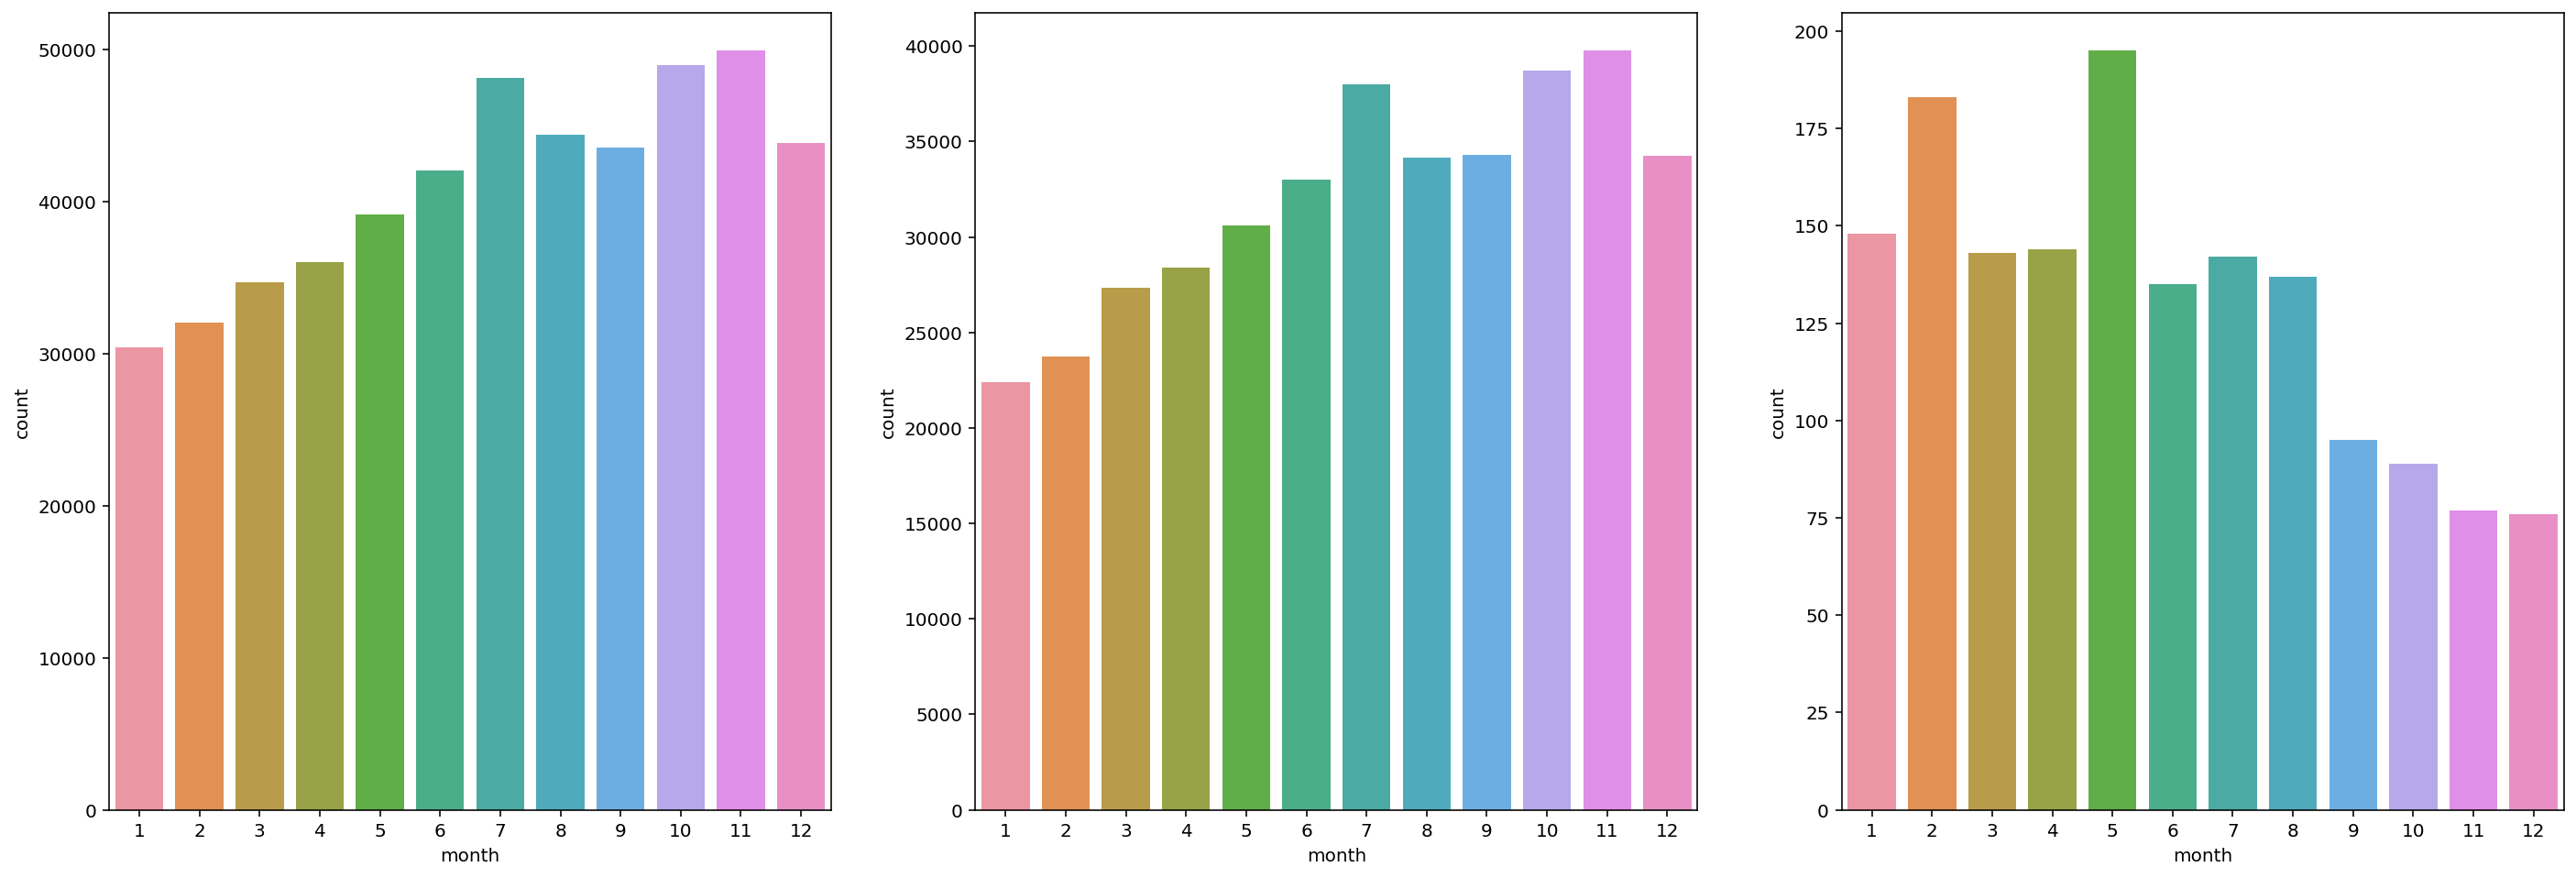

In [325]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(24, 8)
sns.countplot(data=df.query('D_TYPE == "AA"'), x="month", ax=ax1)
sns.countplot(data=df.query('D_TYPE == "BB"'), x="month", ax=ax2)
sns.countplot(data=df.query('D_TYPE == "CC"'), x="month", ax=ax3)


D_TYPE 별 데이터를 
요일 별(day)로 볼 때는 특이점이 보이지 않지만,
주 차별(week)& 월별(month)로 볼 경우 CC 그룹의 경우 AA, BB그룹의 데이터와 달리 꾸준히 count 가 줄어드는 것을 볼 수 있다.


GOODS_TYPE은

1. A 그룹에서 1~61
2. B 그룹에서 1~23
3. C 그룹에서 1~49
4. D 그룹에서 1~40 의 범위를 가짐

A 그룹이 결제 건수가 압도적으로 높고, D 그룹의 결제 건수는 확연히 적음

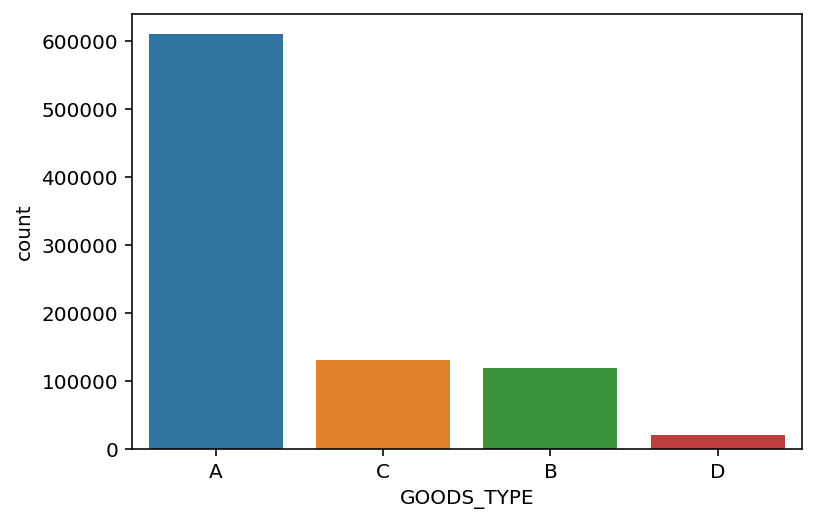

In [326]:
sns.countplot(data=df, x='GOODS_TYPE')

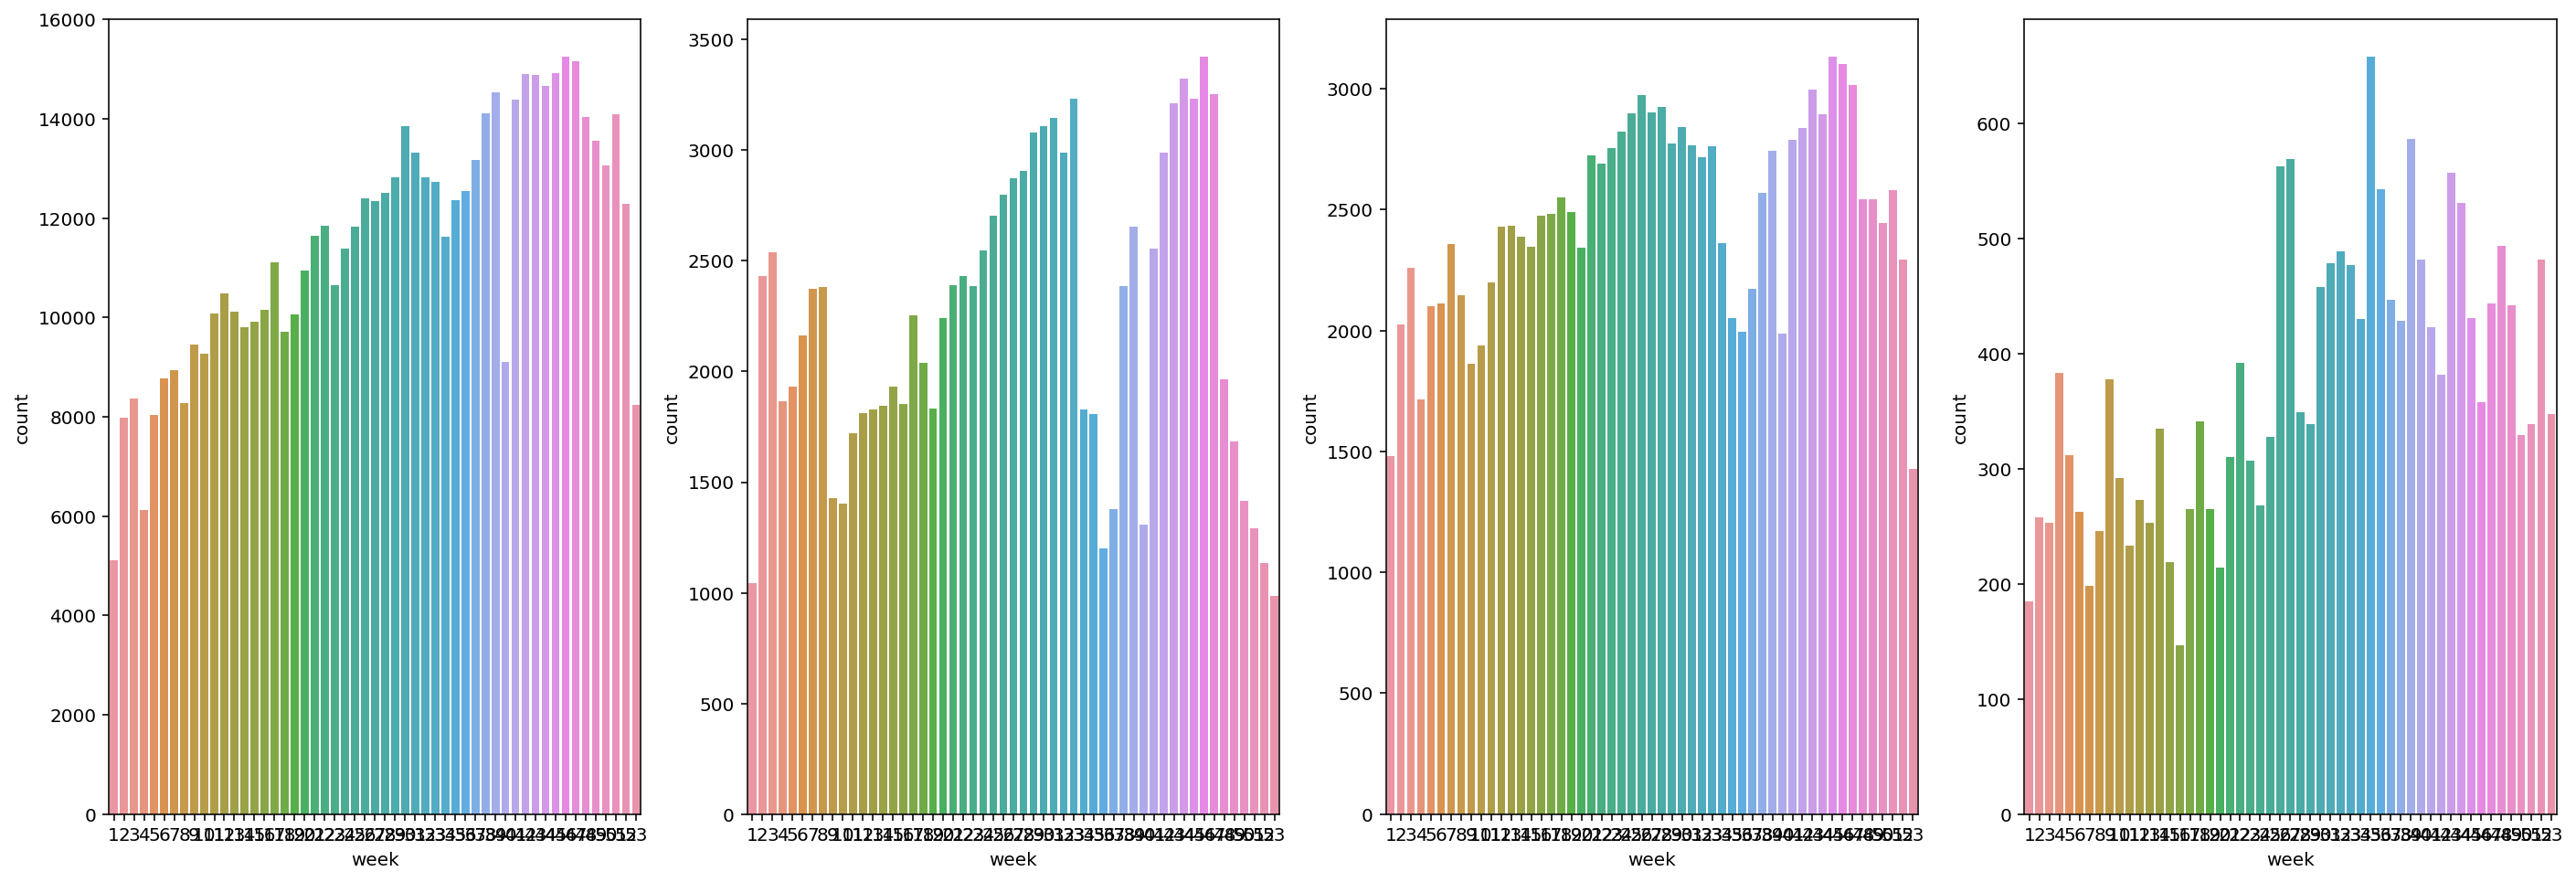

In [327]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(24, 8)
sns.countplot(data=df.query('GOODS_TYPE == "A"'), x="week", ax=ax1)
sns.countplot(data=df.query('GOODS_TYPE == "B"'), x="week", ax=ax2)
sns.countplot(data=df.query('GOODS_TYPE == "C"'), x="week", ax=ax3)
sns.countplot(data=df.query('GOODS_TYPE == "D"'), x="week", ax=ax4)

GOODS_TYPE은 A의 경우만 확연한 증가추세.


### STORE_ID별


<Figure size 1152x720 with 0 Axes>

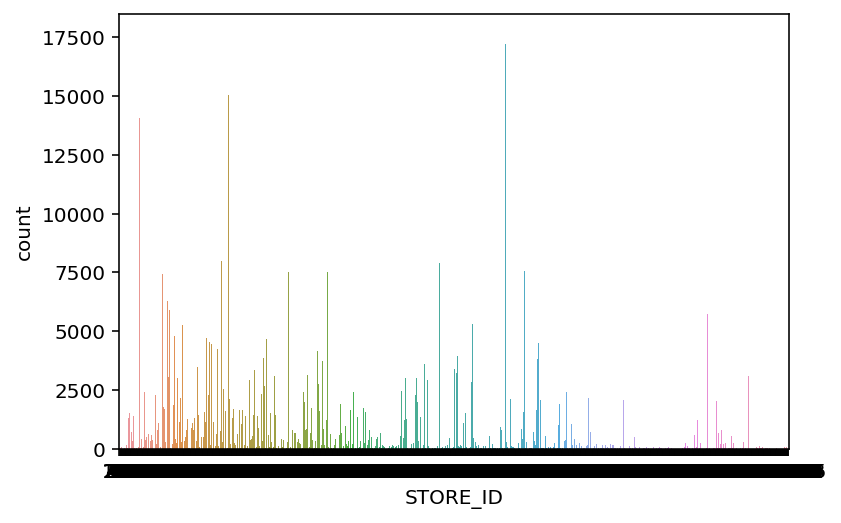

<Figure size 1152x720 with 0 Axes>

In [328]:
sns.countplot(data=df, x='STORE_ID')
plt.figure(figsize=(16,10))

In [329]:
sdf = pd.DataFrame(df.groupby('STORE_ID')['COUNT'].sum())
sdf.reset_index(level=[0], inplace=True)
sdf.sort_values('COUNT', ascending=False, inplace=True)
sdf

,STORE_ID,COUNT
514,220557,17854
612,220893,17653
533,220655,16815
142,92437,16495
603,220848,16298
...,...,...
931,230196,1
927,230190,1
464,220018,1
923,228955,1


In [330]:
slist = sdf.sort_values('COUNT', ascending=False)['STORE_ID'][:10].tolist()
clist = sdf.sort_values('COUNT', ascending=False)['COUNT'][:10].tolist()
slist
clist

[17854, 17653, 16815, 16495, 16298, 15395, 14850, 14612, 12524, 12450]

STORE_ID별 편차가 큼.

In [331]:
df.groupby('USER_ID')['COUNT'].count().max()
# df[df['USER_ID']==232]
df.query('COUNT == COUNT.max()')
df[df['USER_ID'] == 999665]
# df[df['USER_ID'] == 999665]['COUNT'].sum()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week
372,999665,2018-12-16,CC,82399,A,2020-01-01,6,JRR,2,1,1
1527,999665,2018-12-16,CC,104988,A,2020-01-02,11,GN,3,1,1
3121,999665,2018-12-16,CC,181832,A,2020-01-03,7,SC,4,1,1
5034,999665,2018-12-16,CC,109223,A,2020-01-04,28,MP,5,1,1
6919,999665,2018-12-16,CC,104916,A,2020-01-05,14,GN,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...
867260,999665,2018-12-16,CC,2428,A,2020-12-27,17,CY,6,12,52
868847,999665,2018-12-16,CC,109267,A,2020-12-28,24,J,0,12,53
871562,999665,2018-12-16,CC,90193,C,2020-12-29,23,GW,1,12,53
874317,999665,2018-12-16,CC,220797,D,2020-12-30,40,GS,2,12,53


In [332]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   USER_ID     879271 non-null  int64         
 1   JOIN_DATE   879271 non-null  datetime64[ns]
 2   D_TYPE      879271 non-null  object        
 3   STORE_ID    879271 non-null  int64         
 4   GOODS_TYPE  879271 non-null  object        
 5   DATE        879271 non-null  datetime64[ns]
 6   COUNT       879271 non-null  int64         
 7   AD1         879271 non-null  object        
 8   day         879271 non-null  int64         
 9   month       879271 non-null  int64         
 10  week        879271 non-null  int64         
dtypes: datetime64[ns](2), int64(6), object(3)
memory usage: 73.8+ MB


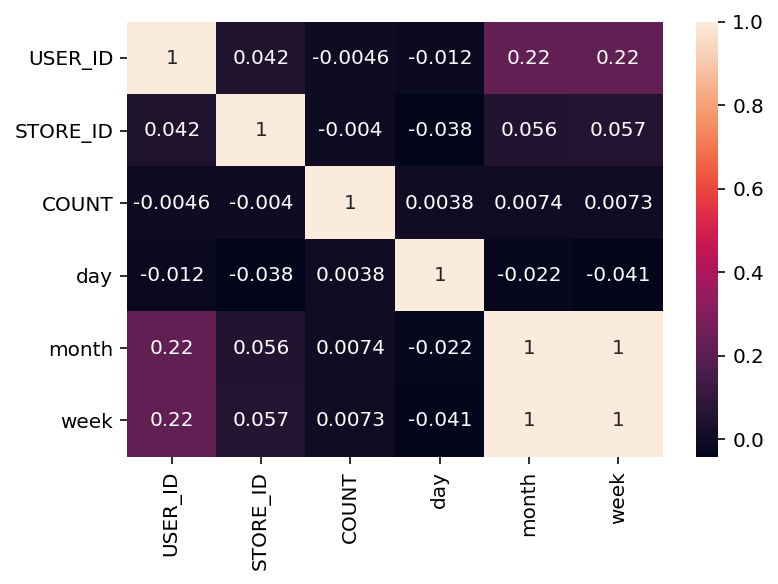

In [333]:
sns.heatmap(df.corr(), annot=True)

사실상 이 히트맵에서는 상관관계는 없다고 보는 게 맞을 듯....
유저 아이디와 회원가입일의 경우는 유저 아이디에 따라 계속해서 반복되기 때문에, 상관관계가 높은 것으로 나옴.


### 2020 공휴일

날짜	요일	공휴일   
1월 1일	수요일	새해  
1월 24일 ~ 1월 26일	금요일 ~ 일요일	설날  
3월 1일	일요일	3·1 운동/삼일절  
4월 30일	목요일	부처님 오신 날  
5월 5일	화요일	어린이날  
6월 6일	토요일	현충일  
8월 15일	토요일	광복절  
8월 17일	월요일	광복절 휴일  
9월 30일 ~ 10월 2일	수요일 ~ 금요일	추석  
10월 3일	토요일	개천절  
10월 9일	금요일	한글날  
12월 25일	금요일	크리스마스  



In [334]:
df.sort_values('COUNT', ascending=False, inplace=True)
# df.groupby("STORE_ID")['COUNT'].value_counts()

### 날짜별 분석


In [335]:
df['day'] = [k for k in df['DATE'].dt.dayofweek] ## 요일 칼럼
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week
729776,999665,2018-12-16,CC,96266,A,2020-11-07,61,GN,5,11,45
748372,999665,2018-12-16,CC,109677,A,2020-11-13,59,JRR,4,11,46
751974,999665,2018-12-16,CC,1109,A,2020-11-14,58,JRR,5,11,46
726277,999665,2018-12-16,CC,190055,A,2020-11-06,55,SB,4,11,45
767392,999665,2018-12-16,CC,131081,A,2020-11-19,53,YO,3,11,47
...,...,...,...,...,...,...,...,...,...,...,...
295494,1579165,2020-05-26,AA,27996,A,2020-05-27,1,J,2,5,22
295495,1579168,2020-05-26,AA,104916,A,2020-05-27,1,GN,2,5,22
295496,1579173,2020-05-26,AA,93362,A,2020-05-27,1,CY,2,5,22
295497,1579174,2020-05-26,BB,221017,A,2020-05-27,1,YD,2,5,22


In [336]:
df['is_weekend'] = df['day'].apply(lambda x: 1 if x > 4 else 0)
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week,is_weekend
729776,999665,2018-12-16,CC,96266,A,2020-11-07,61,GN,5,11,45,1
748372,999665,2018-12-16,CC,109677,A,2020-11-13,59,JRR,4,11,46,0
751974,999665,2018-12-16,CC,1109,A,2020-11-14,58,JRR,5,11,46,1
726277,999665,2018-12-16,CC,190055,A,2020-11-06,55,SB,4,11,45,0
767392,999665,2018-12-16,CC,131081,A,2020-11-19,53,YO,3,11,47,0
...,...,...,...,...,...,...,...,...,...,...,...,...
295494,1579165,2020-05-26,AA,27996,A,2020-05-27,1,J,2,5,22,0
295495,1579168,2020-05-26,AA,104916,A,2020-05-27,1,GN,2,5,22,0
295496,1579173,2020-05-26,AA,93362,A,2020-05-27,1,CY,2,5,22,0
295497,1579174,2020-05-26,BB,221017,A,2020-05-27,1,YD,2,5,22,0


공휴일 분류

In [337]:
h_list = ['2020-01-01', '2020-01-24', '2020-01-25','2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15','2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25']
hol_list =[]
for i in h_list:
  hol = datetime.date(datetime.strptime(i, '%Y-%m-%d'))
  # print(hol)
  hol_list.append(hol)
hol_list

[datetime.date(2020, 1, 1),
 datetime.date(2020, 1, 24),
 datetime.date(2020, 1, 25),
 datetime.date(2020, 1, 26),
 datetime.date(2020, 3, 1),
 datetime.date(2020, 4, 30),
 datetime.date(2020, 5, 5),
 datetime.date(2020, 6, 6),
 datetime.date(2020, 8, 15),
 datetime.date(2020, 8, 17),
 datetime.date(2020, 9, 30),
 datetime.date(2020, 10, 1),
 datetime.date(2020, 10, 2),
 datetime.date(2020, 10, 3),
 datetime.date(2020, 10, 9),
 datetime.date(2020, 12, 25)]

In [338]:
df['is_holiday'] = df['DATE'].apply(lambda x: 1 if x in hol_list else 0)

In [339]:
df.query('is_holiday == 1')['COUNT'].sum()/df.query('is_holiday == 1')['COUNT'].count()

1.0331672248999264

In [340]:
df.query('is_holiday == 0')['COUNT'].sum()/df.query('is_holiday == 0')['COUNT'].count()

1.0289615331970814

In [341]:
df.query('day < 6 and is_holiday == 0')['COUNT'].sum()/df.query('is_weekend == 0 and is_holiday == 0')['COUNT'].count()

1.226101431137252

In [342]:
df.query('day <6 and is_holiday == 1')['COUNT'].sum()/df.query('day > 5 and is_holiday == 1')['COUNT'].count()

11.867414584395716

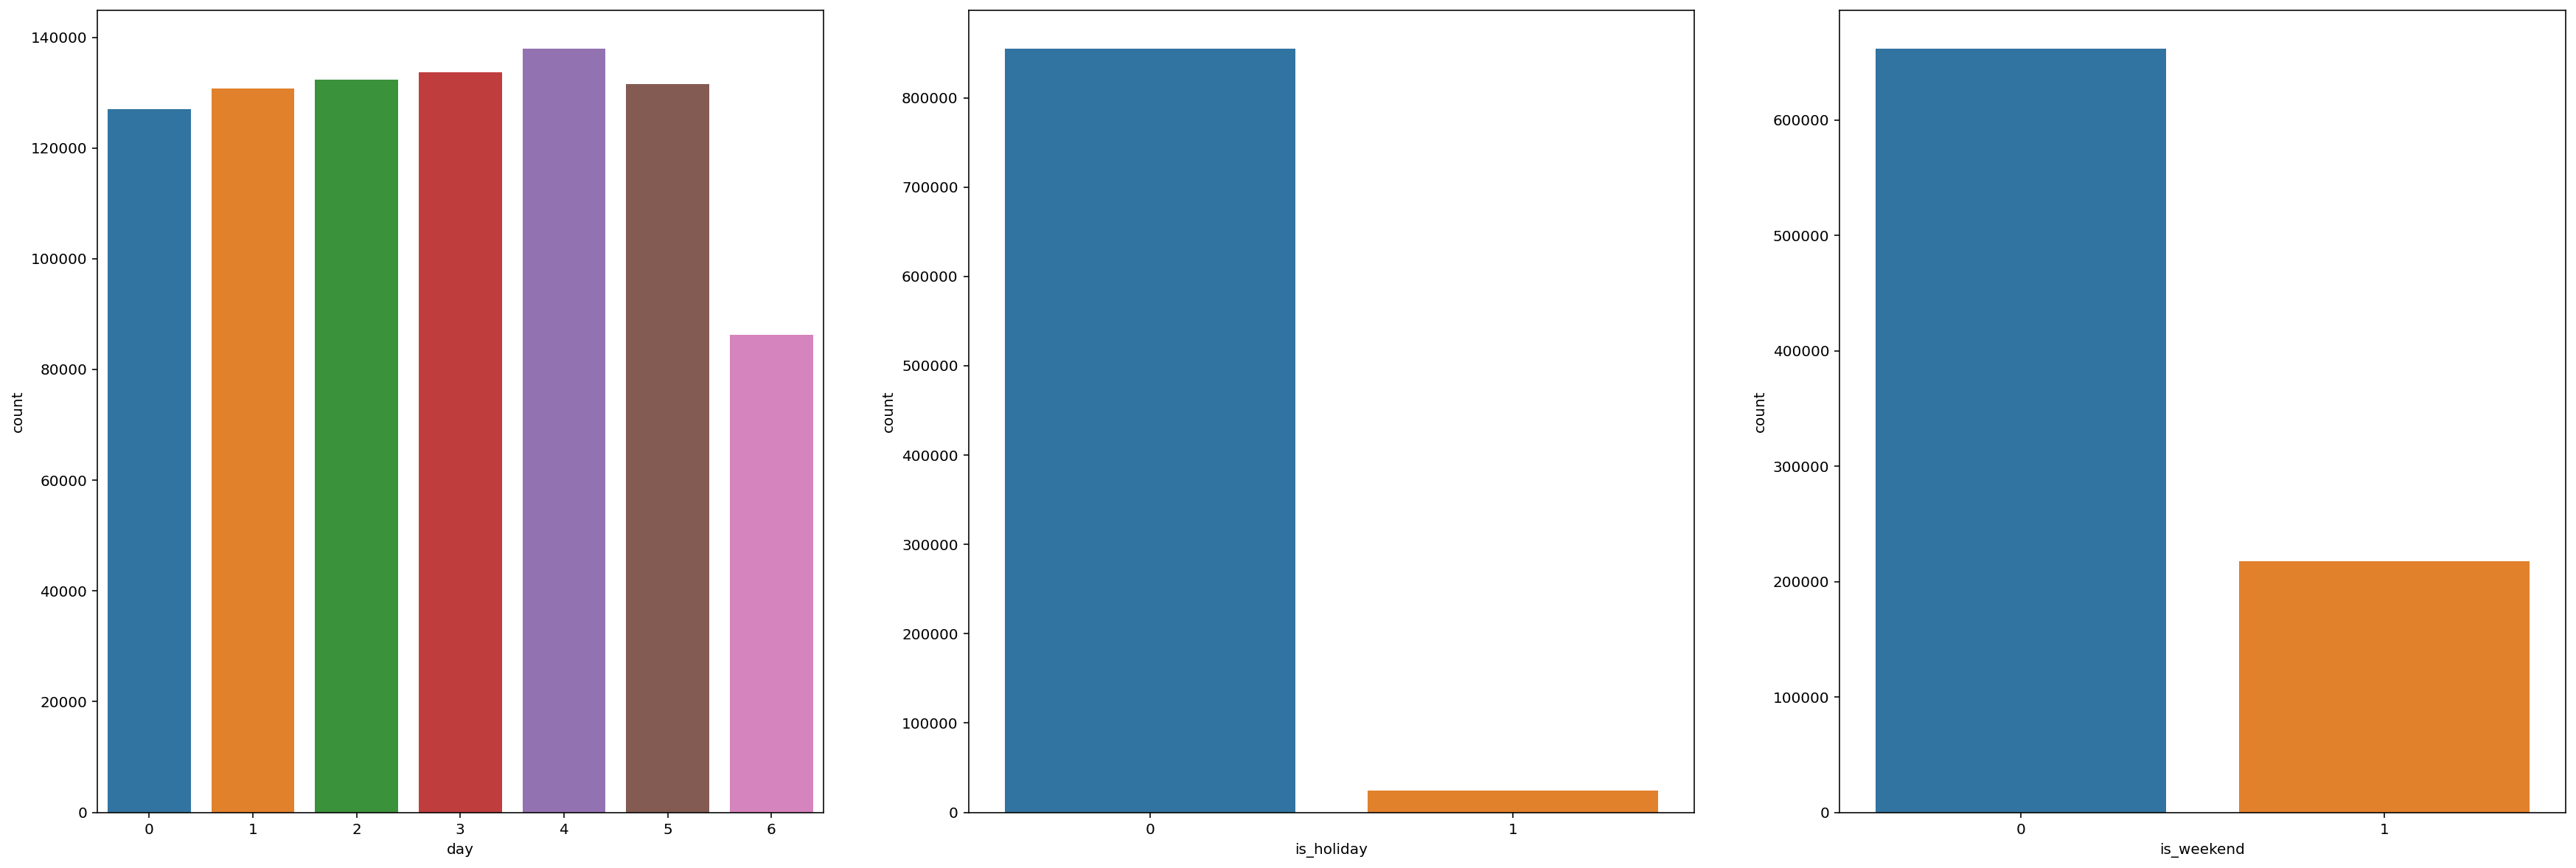

In [343]:
df.groupby('day')['COUNT'].sum()
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(30, 10)
# sns.barplot(data = df.groupby('day')['COUNT'].sum(), x = 'day')
sns.countplot(data=df, x='day', ax = ax1)
sns.countplot(data=df, x='is_holiday', ax = ax2)
sns.countplot(data=df, x='is_weekend', ax = ax3)

주말, 특히 일요일의 경우 결제 건수가 확연히 줄어드는 것을 볼 수 있고,
주말인 경우와 공휴일의 경우 절대적인 날짜의 차이가 있기때문에, 차이를 볼 수 있지만, 날짜 대비 결제 건수는 주말과 공휴일에 늘어나는 것을 볼 수 있다.


### 요일별  각 상품 이용량 분석

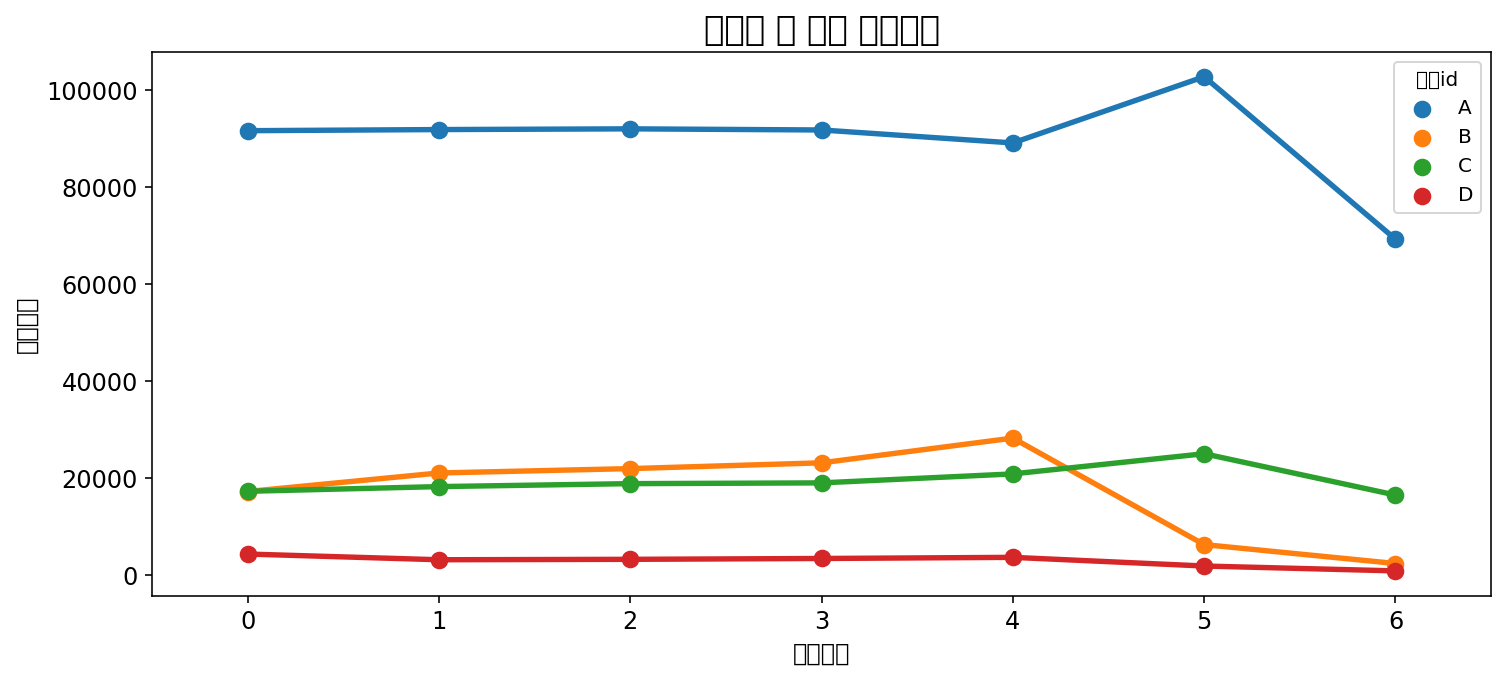

In [344]:
#요일별 이용량 분석

df['DAY'] = df['DATE'].dt.weekday
counts_days = df.groupby(['DAY','GOODS_TYPE'])['COUNT'].sum().reset_index()
counts_days_df = counts_days[['DAY','GOODS_TYPE','COUNT']]
counts_days_df.columns = ['결제요일','상품id','결제건수']

fig, ax = plt.subplots(1,1, figsize = (12,5))
sns.pointplot(x = '결제요일', y = '결제건수', hue = '상품id', data = counts_days_df)
plt.title('요일별 각 상품 결제건수', fontsize = 17)
plt.xlabel('결제요일', fontsize = 12)
plt.ylabel('결제건수', fontsize = 12)
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12)
plt.show()

### 요일별 상품 결제 건수에 대해서는 GOODS_TYPE 이 A일 때, 토요일에 결제건수가 평일 대비 높은 것을 볼 수 있다.
이를 통해 확인 할 수 있는 것은,
1. A의 결제건수가 가장 많으므로 시간권으로 예상할 수 있다.
2. B의 결제건수가 주말이 되면 크게 줄어들기 때문에 평일 당일권임을 추측할 수 있다.
3. C의 결제건수는 주말이 되면 오히려 증가하므로 휴일 당일권일 것으로 추측했다.
4. D의 결제건수는 가장 적고 주말에 감소하는 경향이 있어서 평일 심야권일 것으로 생각했다.

In [345]:
df.query('GOODS_TYPE == "A" and day == 6')['COUNT'].sum()
df.loc[df['GOODS_TYPE']=='A'].groupby('day')["COUNT"].sum()

day
0     91607
1     91838
2     91987
3     91754
4     89083
5    102734
6     69250
Name: COUNT, dtype: int64

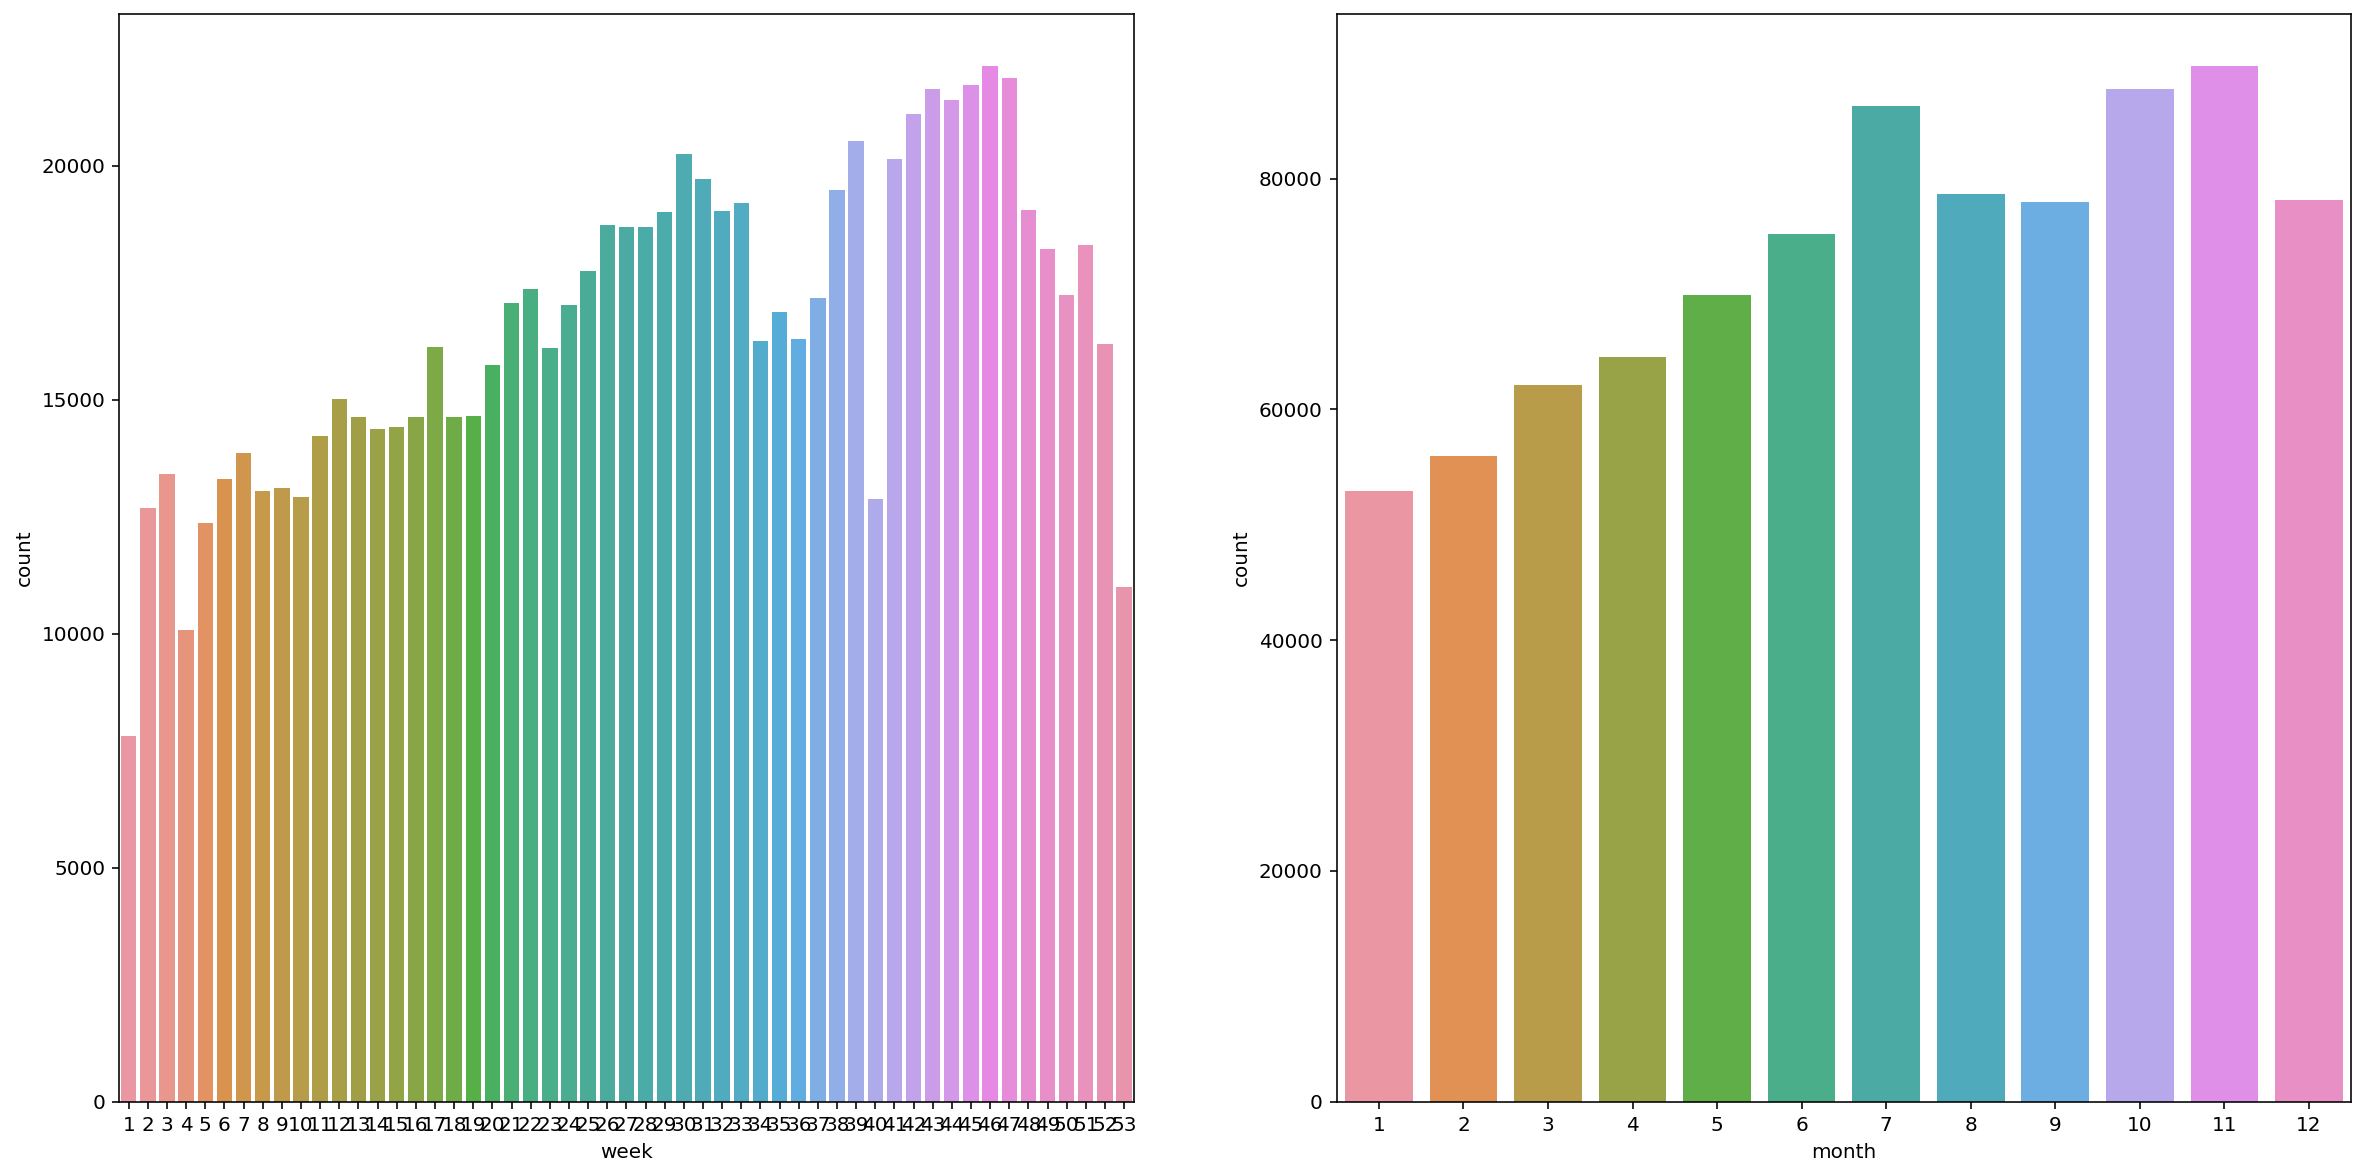

In [346]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20,10)
sns.countplot(data=df, x='week', ax=ax1)
sns.countplot(data=df, x='month', ax=ax2)

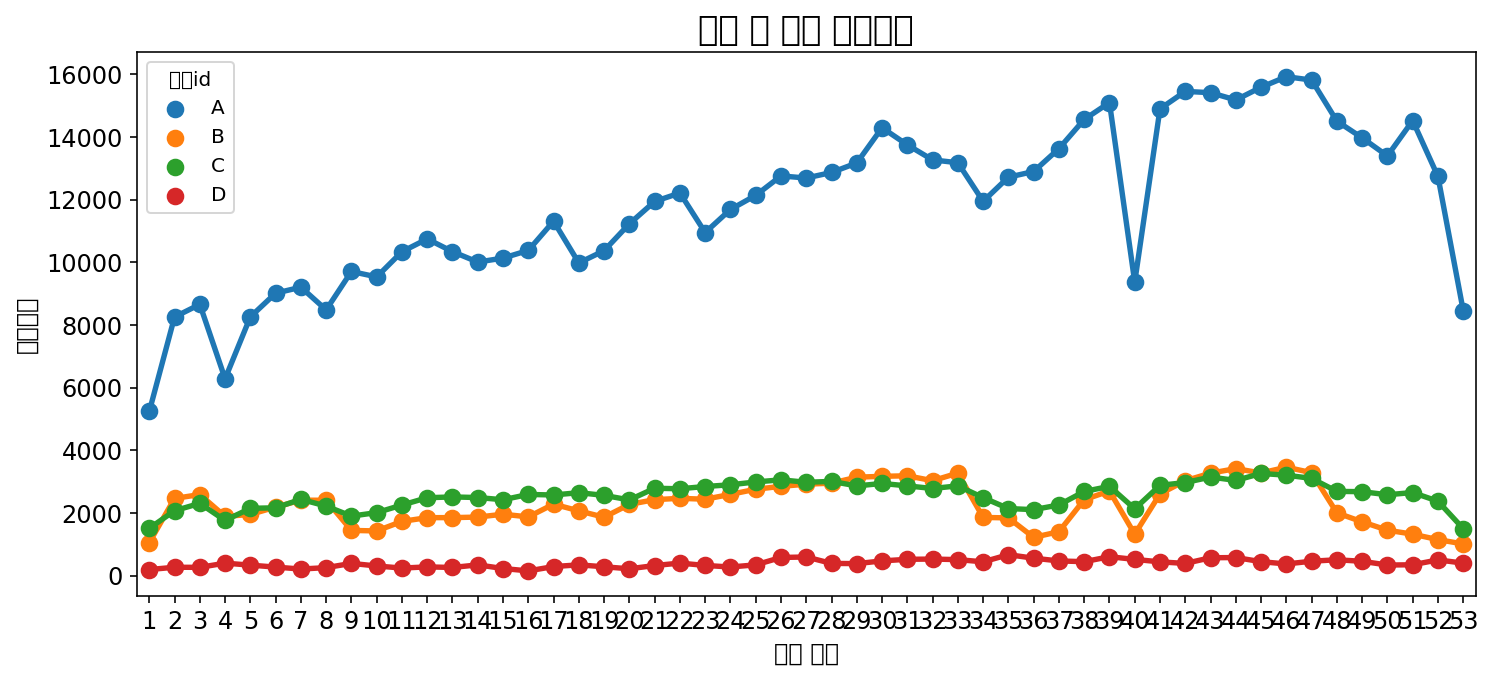

In [347]:
df.loc[df['GOODS_TYPE']=='A'].groupby('week')["COUNT"].sum()

counts_days = df.groupby(['week','GOODS_TYPE'])['COUNT'].sum().reset_index()
counts_days_df = counts_days[['week','GOODS_TYPE','COUNT']]
counts_days_df.columns = ['주','상품id','결제건수']

fig, ax = plt.subplots(1,1, figsize = (12,5))
sns.pointplot(x = '주', y = '결제건수', hue = '상품id', data = counts_days_df)
plt.title('주별 각 상품 결제건수', fontsize = 17)
plt.xlabel('결제 주차', fontsize = 12)
plt.ylabel('결제건수', fontsize = 12)
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12)
plt.show()

In [348]:
df.query('week == 41')['COUNT'].sum() # 20816
df.query('week == 40')['COUNT'].sum() # 13329
df.query('week == 40') ## 추석이 있는 주
df.query('week == 34') ## 광복절, 대체연휴가 있는 주

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week,is_weekend,is_holiday,DAY
517910,999665,2018-12-16,CC,105274,C,2020-08-20,31,CY,3,8,34,0,0,3
515223,999665,2018-12-16,CC,221018,A,2020-08-19,24,MP,2,8,34,0,0,2
520614,999665,2018-12-16,CC,219891,A,2020-08-21,22,ZE,4,8,34,0,0,4
512451,999665,2018-12-16,CC,90193,C,2020-08-18,22,GW,1,8,34,0,0,1
510288,999665,2018-12-16,CC,220893,A,2020-08-17,21,J,0,8,34,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517311,428194,2016-12-13,AA,109422,A,2020-08-20,1,J,3,8,34,0,0,3
517312,428836,2016-12-14,AA,96266,A,2020-08-20,1,GN,3,8,34,0,0,3
517313,429225,2016-12-14,BB,109421,A,2020-08-20,1,J,3,8,34,0,0,3
517314,431298,2016-12-18,AA,220848,B,2020-08-20,1,GN,3,8,34,0,0,3


### 월별로 보면 주로 겨울에 비해 여름과 특히 가을에 사용량이 비교적 많은 편
### 주차별로 확인 할 경우, 연초와 연말 그리고 추석이 있는 주 차에서 이용량이 급감

In [349]:
# def make_season(sent):
#     if sent < 3 or sent >11:
#         season = '겨울'
#     elif sent >= 3 and sent < 6:
#         season = '봄'
#     elif sent >= 6 and sent < 9:
#         season = "여름"
#     elif sent >= 9 and sent < 12:
#         season = '가을'
#     return season
# df['season'] = df['month'].apply(lambda x: make_season(x))

In [350]:
cdf.query('day == 6 or day == 7')
cdf.query('day < 6 ')

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week
372,999665,2018-12-16,CC,82399,A,2020-01-01,6,JRR,2,1,1
437,1081430,1970-01-01,CC,90070,A,2020-01-01,1,GD,2,1,1
1527,999665,2018-12-16,CC,104988,A,2020-01-02,11,GN,3,1,1
2196,1410151,1970-01-01,CC,92437,B,2020-01-02,1,J,3,1,1
2204,1415023,1970-01-01,CC,131081,A,2020-01-02,1,YO,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...
871598,1035854,2019-01-14,CC,92505,A,2020-12-29,1,J,1,12,53
873707,1828010,1970-01-01,CC,220635,C,2020-12-29,1,GN,1,12,53
874317,999665,2018-12-16,CC,220797,D,2020-12-30,40,GS,2,12,53
877120,999665,2018-12-16,CC,220893,A,2020-12-31,42,J,3,12,53


---
## AD1 별

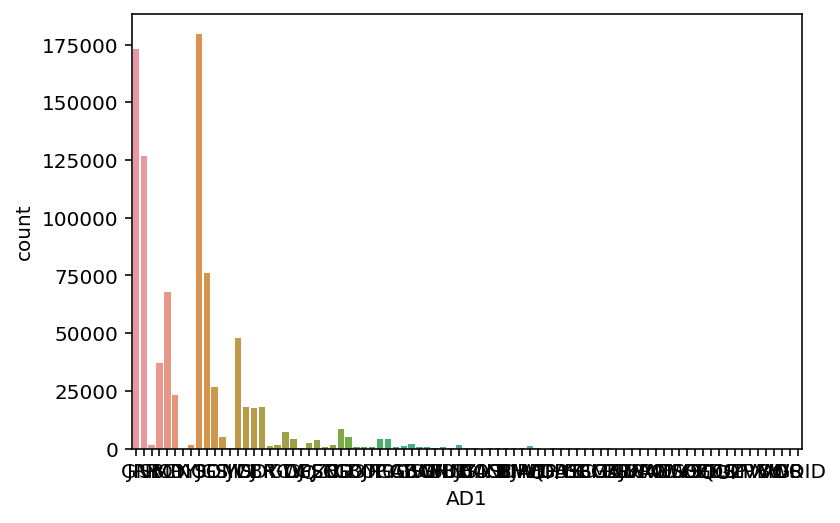

In [351]:
sns.countplot(data=df, x='AD1')

In [352]:
df.groupby('AD1')['COUNT'].value_counts()
ad_df = df.groupby('AD1')['COUNT'].sum().sort_values(ascending=False).reset_index()
ad_df

,AD1,COUNT
0,J,184660
1,GN,178190
2,JRR,130476
3,SC,78176
4,MP,69277
...,...,...
80,SP,3
81,VO,1
82,NW,1
83,ADS,1


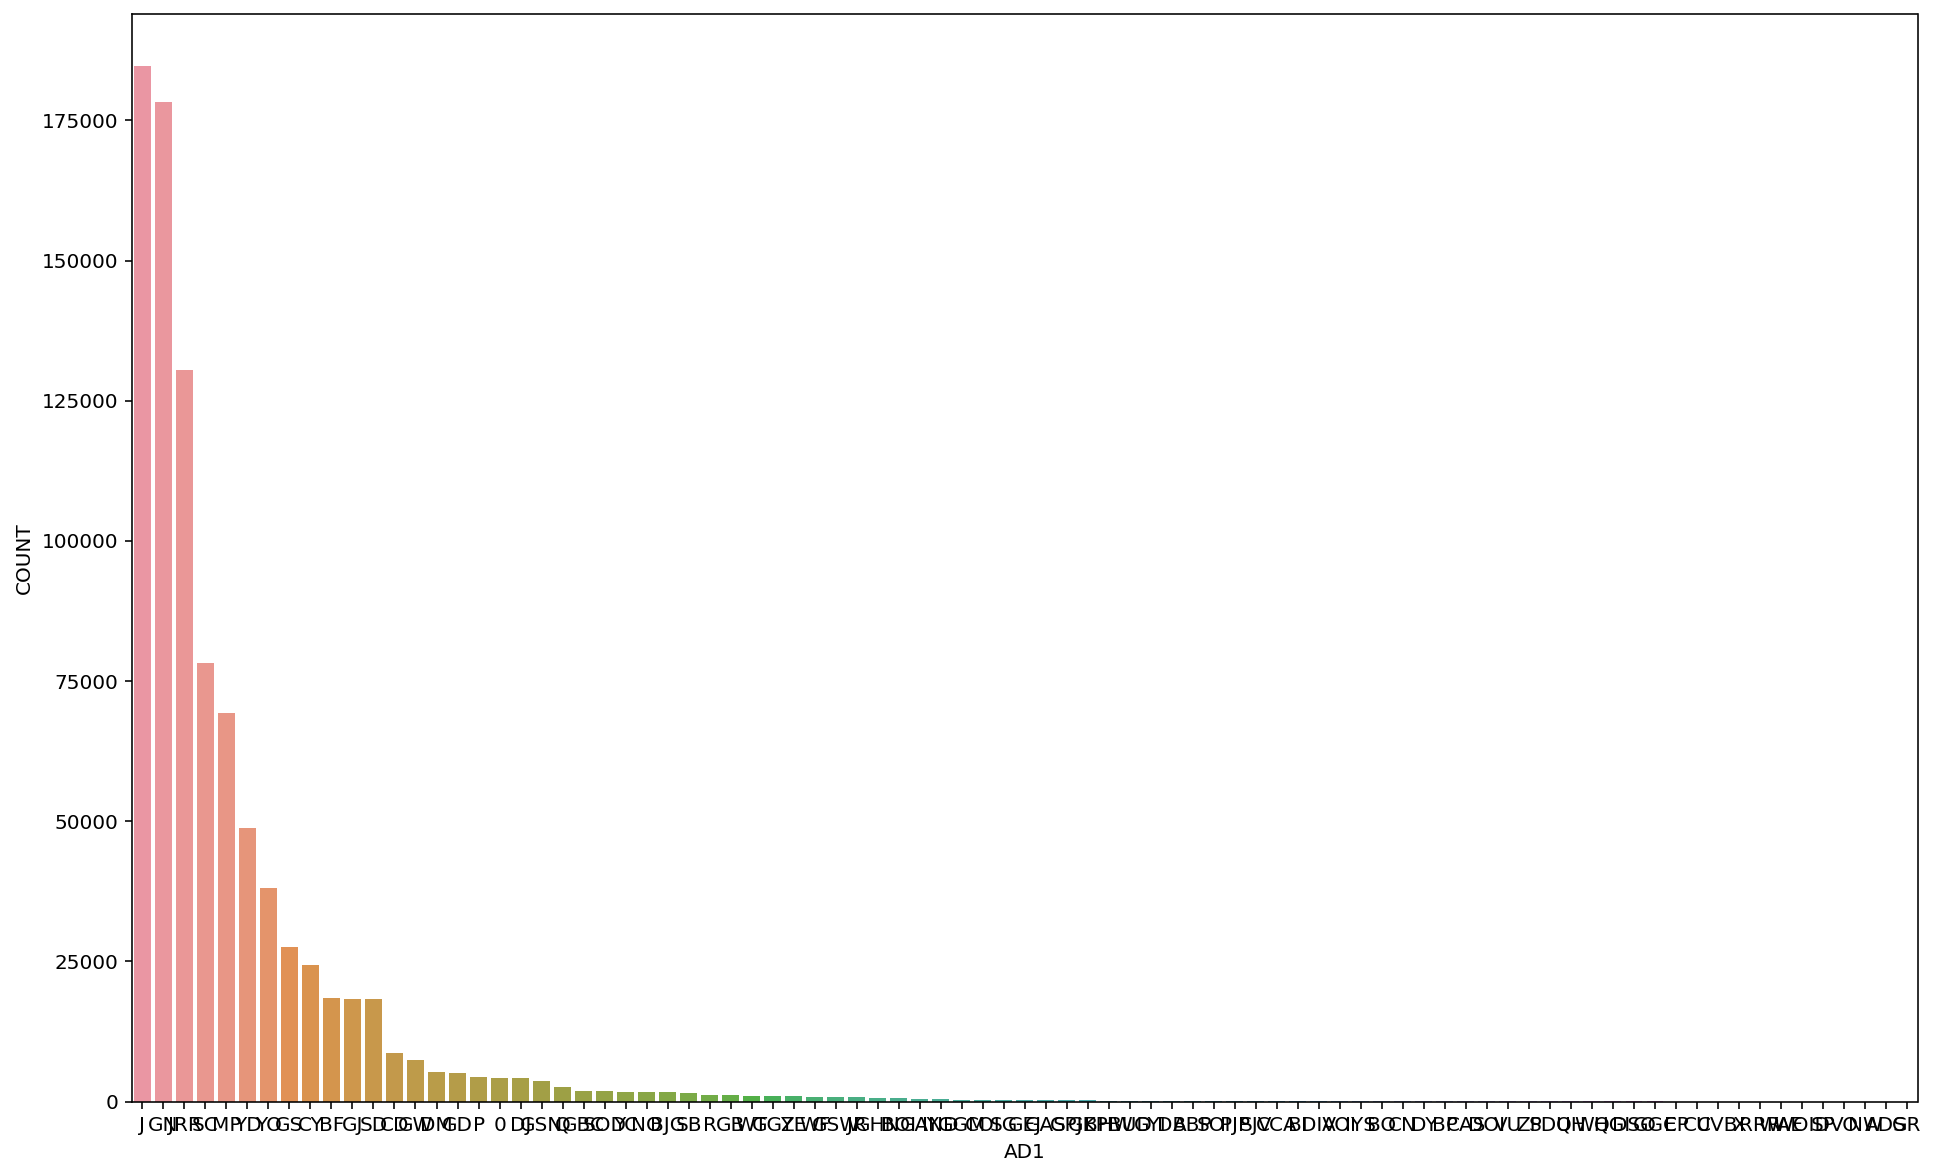

In [353]:
fig, ax = plt.subplots(ncols=1, nrows=1)
fig.set_size_inches(16,10)
sns.barplot(data=ad_df, x='AD1', y='COUNT', ax=ax)



- AD1 별로 결제 건수의 편차가 심함.
- STORE_ID의 plot과 비슷한 형태인 것으로 파악됨
- AD1과 STORE_ID와의 연관성 파악할 필요성 느낌

## STORE_ID와 AD1과의 상관관계

In [354]:
df.groupby(['AD1','STORE_ID'])['COUNT'].sum() # 1061
# ad1store_df = ad1store.to_frame()
# ad1store_df.sort_values(['AD1','COUNT'])
# len(df['STORE_ID'].unique()) # 1061

AD1  STORE_ID
0    157708       296
     172827      2409
     173849        70
     190306        22
     203766        42
                 ... 
ZE   222384        60
     222385        19
     223124         1
ZP   220973        23
     221040         7
Name: COUNT, Length: 1061, dtype: int64

In [355]:
#STORE_ID와 AD1과의 상관관계
ad_list = df['AD1'].unique().tolist()
ndf_list = []
for i in ad_list :
    ndf = df[df['AD1']==i]
    ndf_list.append(ndf)
    print(i,"의 STORE_ID 리스트 : ", ndf['STORE_ID'].unique())

GN 의 STORE_ID 리스트 :  [ 96266 220607   1900 109832   2058  90542 109905  83199 220689 220578
 228946  90545 190482 221045  90461 220700 207620 190483 220071 219913
  82429  90444 109796  90447 104916   1892 104988 220848  90448 221022
 222819 109839 220685 220284 131080  82430 220906 109780  82407 231045
  90500 220690  90445 104905 219886    472 207623 204458 106347 108963
 109768 137450  97308 220773 203642 220635 220850 220259 204526 220660
 109805 220087 219888  96257 105426 173176 204443 190054 109877 220971
 106329 220667 106112 223653 228941 220962 220692 220735   2457   1070
 204444 173872 221013 231434 109819 181817 231087 219977 230732  96255
 231406 223135 222317 220612 230836  90473 222313   1053 105424 204481
 220933 220854 109745 220628 220394 108914  90433    774  90516 228926
 223650 220582 220680   1058 105345 229411 223012 106355 228962 223025
 222381 222210 230736 204535 204500    456 230866 220377 106353 222238
 109801 222331 231041 230998 231444 231428 173848 220763

SG 의 STORE_ID 리스트 :  [182781 220915 220916 220750 220806 222419 220706]
CCA 의 STORE_ID 리스트 :  [220673 223626]
GEJ 의 STORE_ID 리스트 :  [223013 223022 222400 223016 227434 223020 106150]
CU 의 STORE_ID 리스트 :  [230902 230196]
RRR 의 STORE_ID 리스트 :  [108837]
GKP 의 STORE_ID 리스트 :  [190274 220765 230190 230191 220384 231029 231115]
DIV 의 STORE_ID 리스트 :  [220713 225667 225669]
WAE 의 STORE_ID 리스트 :  [230734 230733]
AOI 의 STORE_ID 리스트 :  [220922 222358 220923 106119 220742]
VU 의 STORE_ID 리스트 :  [220783 230989]
NW 의 STORE_ID 리스트 :  [225653]
DSO 의 STORE_ID 리스트 :  [225680 106256  68628 230963 225668 225639 220307]
SOI 의 STORE_ID 리스트 :  [220928]
EP 의 STORE_ID 리스트 :  [220974]
GGC 의 STORE_ID 리스트 :  [220807]
SDU 의 STORE_ID 리스트 :  [225656 225674 225672 225671 225655 231090 231091 225670 225676]
QGI 의 STORE_ID 리스트 :  [220383]
DOI 의 STORE_ID 리스트 :  [222378 190218 220924 203835]
SP 의 STORE_ID 리스트 :  [220705 181991]
ZP 의 STORE_ID 리스트 :  [221040 220973]
CVB 의 STORE_ID 리스트 :  [220709 231093]
X 의 STORE_ID 리스트 :  

In [356]:
ndf_list

[        USER_ID  JOIN_DATE D_TYPE  STORE_ID GOODS_TYPE       DATE  COUNT AD1  \
 729776   999665 2018-12-16     CC     96266          A 2020-11-07     61  GN   
 764097   999665 2018-12-16     CC    220607          A 2020-11-18     49  GN   
 705100   999665 2018-12-16     CC      1900          C 2020-10-30     49  GN   
 777538   999665 2018-12-16     CC    109832          A 2020-11-22     47  GN   
 711885   999665 2018-12-16     CC    109832          A 2020-11-01     45  GN   
 ...         ...        ...    ...       ...        ...        ...    ...  ..   
 295475  1578458 2020-05-25     AA     82407          A 2020-05-27      1  GN   
 295482  1578659 2020-05-26     AA    104988          A 2020-05-27      1  GN   
 295484  1578663 2020-05-26     BB    221045          A 2020-05-27      1  GN   
 295488  1578797 2020-05-26     BB    106347          C 2020-05-27      1  GN   
 295495  1579168 2020-05-26     AA    104916          A 2020-05-27      1  GN   
 
         day  month  week 

In [357]:
df.query('JOIN_DATE == 1970 and D_TYPE =="CC"')
df.query('JOIN_DATE != 1970 and D_TYPE =="CC"')

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week,is_weekend,is_holiday,DAY
729776,999665,2018-12-16,CC,96266,A,2020-11-07,61,GN,5,11,45,1,0,5
748372,999665,2018-12-16,CC,109677,A,2020-11-13,59,JRR,4,11,46,0,0,4
751974,999665,2018-12-16,CC,1109,A,2020-11-14,58,JRR,5,11,46,1,0,5
726277,999665,2018-12-16,CC,190055,A,2020-11-06,55,SB,4,11,45,0,0,4
767392,999665,2018-12-16,CC,131081,A,2020-11-19,53,YO,3,11,47,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287530,1393530,2019-11-15,CC,220721,C,2020-05-24,1,BF,6,5,21,1,0,6
282415,1393529,2019-11-15,CC,220722,A,2020-05-22,1,BF,4,5,21,0,0,4
299887,1393530,2019-11-15,CC,220721,A,2020-05-29,1,BF,4,5,22,0,0,4
302692,1393530,2019-11-15,CC,220721,A,2020-05-30,1,BF,5,5,22,1,0,5


In [358]:
## STORE_ID 별 AD1의 값 변동 여부 확인
from tqdm import tqdm

store_list = df["STORE_ID"].unique().tolist()
for i in tqdm(store_list):
  # print(df[df['USER_ID']==i]["D_TYPE"])
  str_list = df[df['STORE_ID']==i]["AD1"].tolist()
  # print(str_list)
  for s in str_list:
    
    if ch_list.count(c) != len(ch_list):
      # print(ch_list.count(c), len(ch_list))
      print('{}의 AD1이 다름'.format(i))
    

100%|█████████████████████████████████████████████████████████████████████████████| 1061/1061 [00:01<00:00, 685.69it/s]


### STORE_ID 별 AD1값은 변동되지 않음 -> 각각 STORE_ID 별로 AD1 값이 할당되었다고 볼 수 있음 

이를 통해 AD1을 주소로 가정 및 이니셜 및 결제건수를 통해 지역구 추정

+ 서울 지역구  
1. 종로구 : JR
2. 중구 : J
3. 용산구 : YO
4. 성동구 : SOD
5. 광진구 : GJ
6. 동대문구 : DM
7. 중랑구 : JRR
8. 성북구 : SB
9. 강북구 : GB
10. 도봉구 : DB
11. 노원구 : NW
12. 은평구 : EP
13. 서대문구 : SD
14. 마포구 : MP
15. 양천구 : YC
16. 강서구 : GS
17. 구로구 : GR
18. 금천구 : GHN
19. 영등포구 : YD
20. 동작구 : DJ
21. 관악구 : GW
22. 서초구 : SC
23. 강남구 : GN
24. 송파구 : SP
25. 강동구 : GD



Text(0.5, 1.0, 'BB')

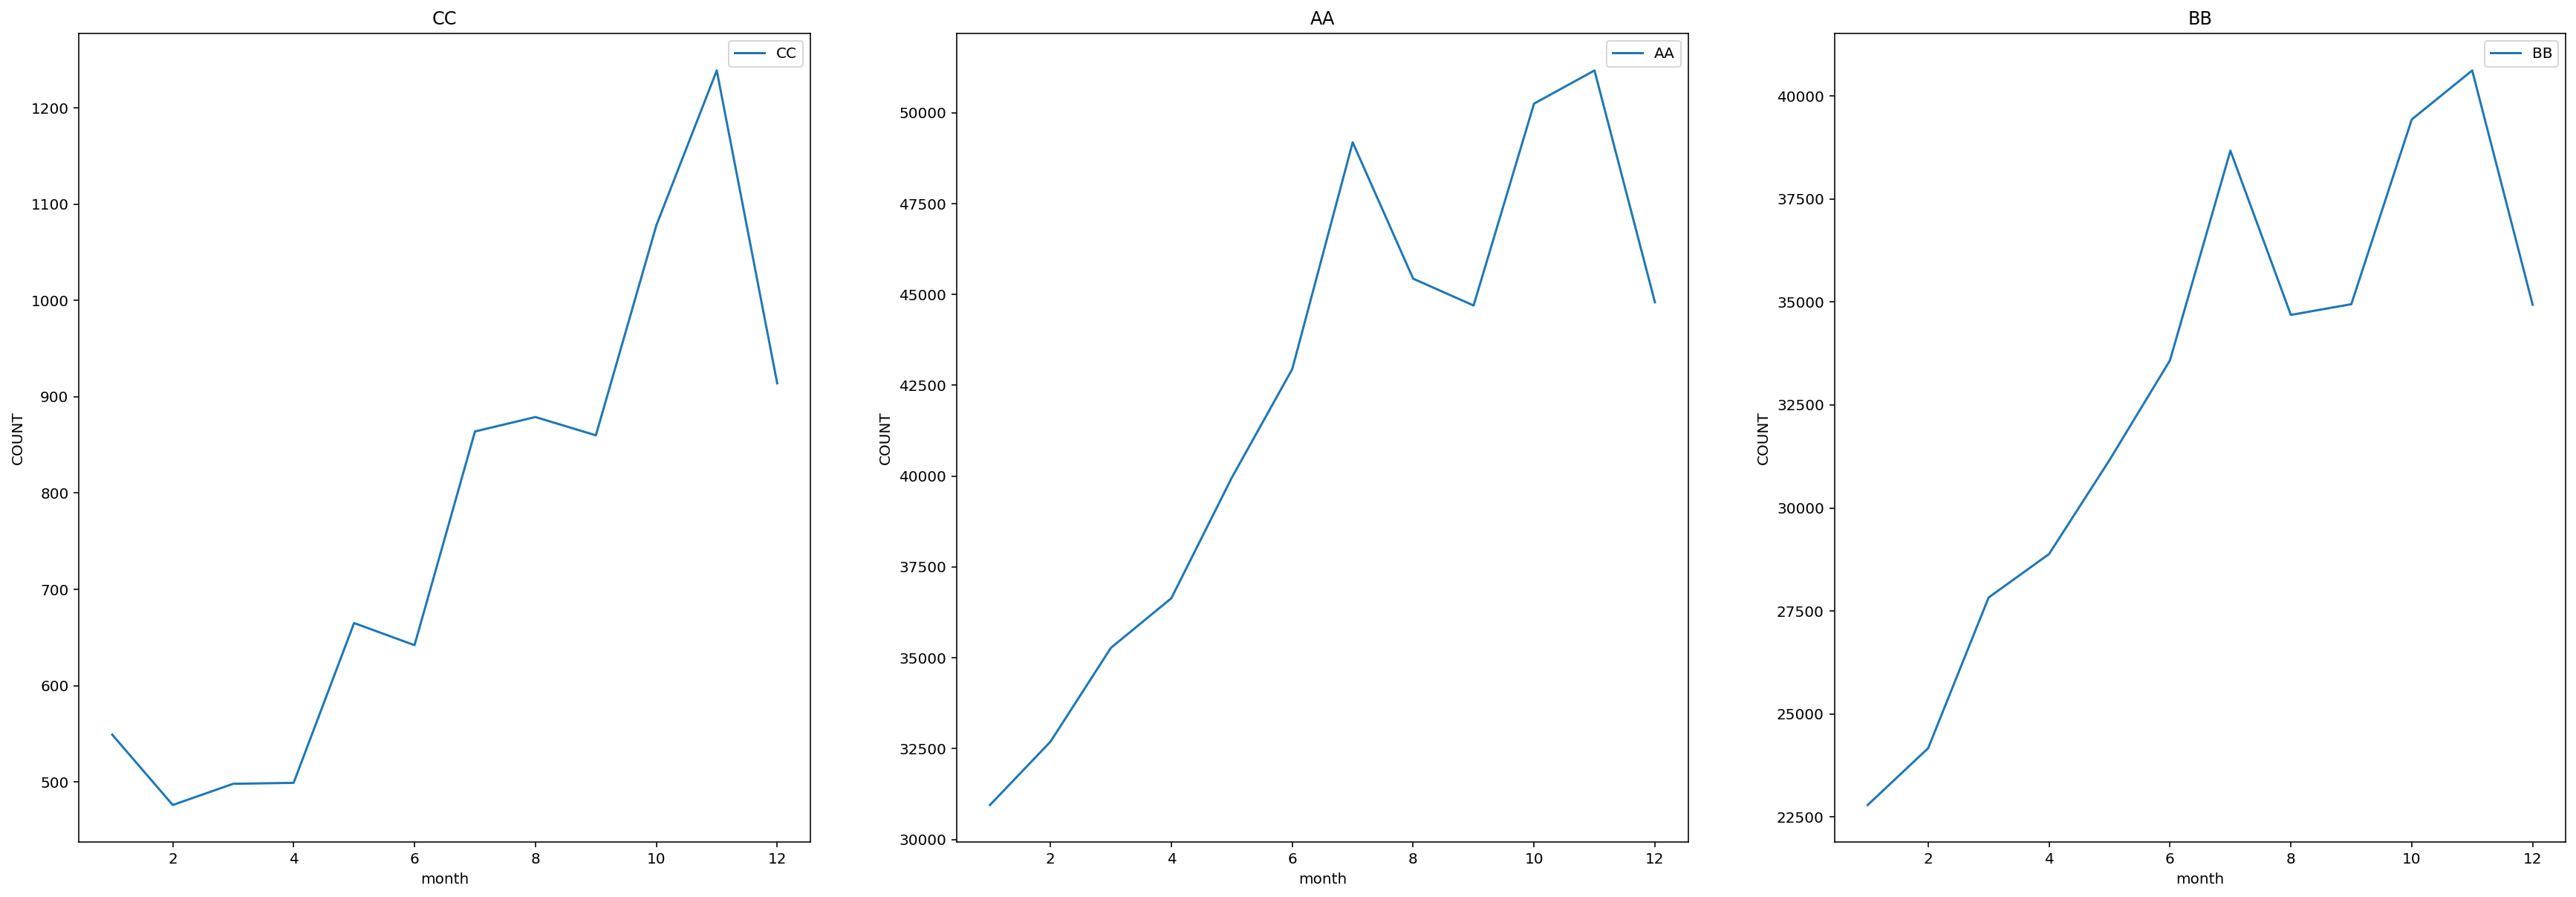

In [359]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(30,10)
count_df = cdf.groupby('month')['COUNT'].sum().reset_index()
count_df2 = adf.groupby('month')['COUNT'].sum().reset_index()
count_df3 = bdf.groupby('month')['COUNT'].sum().reset_index()
sns.lineplot(data=count_df, x='month', y = 'COUNT', label = 'CC', ax=ax1).set_title('CC')
sns.lineplot(data=count_df2, x='month', y = 'COUNT', label = 'AA', ax=ax2).set_title('AA')
sns.lineplot(data=count_df3, x='month', y = 'COUNT', label="BB", ax=ax3).set_title('BB')

## 외부 데이터
### 기상 자료 확인

In [360]:
weather

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01 1:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2
1,108,2020-01-01 2:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1
2,108,2020-01-01 3:00,-5.6,0.0,0.0,46,NaN,NaN,-2.7,3.1
3,108,2020-01-01 4:00,-5.4,NaN,0.0,50,NaN,NaN,-2.5,3.0
4,108,2020-01-01 5:00,-5.2,NaN,0.0,55,NaN,NaN,-2.2,3.0
...,...,...,...,...,...,...,...,...,...,...
8755,108,2020-12-30 20:00,-11.8,NaN,4.8,54,NaN,NaN,-6.5,2.2
8756,108,2020-12-30 21:00,-12.4,NaN,3.2,58,NaN,NaN,-6.9,2.2
8757,108,2020-12-30 22:00,-12.7,NaN,2.8,56,NaN,NaN,-7.1,2.1
8758,108,2020-12-30 23:00,-12.9,NaN,2.2,54,NaN,NaN,-7.3,2.1


결측치 확인

In [361]:
weather.isnull().sum()

지점         0
일시         0
기온         1
강수량     7701
풍속         0
습도         0
일조시간    3969
적설량     8552
지면온도       8
지중온도      12
dtype: int64

In [362]:
## DATE 컬럼 생성 JOIN시 편의
weather['DATE']= weather['일시'].apply(lambda x : datetime.strptime(x[:10], '%Y-%m-%d'))

In [363]:
## 기온 결측치 처리
np.where(weather.기온.isnull()) # 5724
weather.iloc[5724]
weather[weather['DATE']=='2020-08-26']

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,DATE
5711,108,2020-08-26 0:00,28.7,NaN,2.7,76,NaN,NaN,27.1,27.9,2020-08-26
5712,108,2020-08-26 1:00,28.4,NaN,2.1,77,NaN,NaN,26.6,27.9,2020-08-26
5713,108,2020-08-26 2:00,28.1,NaN,1.8,79,NaN,NaN,26.1,27.8,2020-08-26
5714,108,2020-08-26 3:00,27.6,NaN,2.0,80,NaN,NaN,25.8,27.8,2020-08-26
5715,108,2020-08-26 4:00,27.3,NaN,2.0,82,NaN,NaN,25.6,27.8,2020-08-26
5716,108,2020-08-26 5:00,27.2,NaN,2.1,82,NaN,NaN,25.4,27.8,2020-08-26
5717,108,2020-08-26 6:00,27.0,NaN,2.9,82,0.0,NaN,25.3,27.7,2020-08-26
5718,108,2020-08-26 7:00,27.3,NaN,2.7,82,0.6,NaN,25.8,27.7,2020-08-26
5719,108,2020-08-26 8:00,28.6,NaN,2.7,79,1.0,NaN,28.1,27.6,2020-08-26
5720,108,2020-08-26 9:00,29.7,NaN,3.2,74,0.8,NaN,31.2,27.6,2020-08-26


In [364]:
# 결측치 대체 후 null값 제대로 채워졌는지 확인
weather['기온'] = weather['기온'].fillna((33.3+34.1)/2)
weather[weather['DATE']=='2020-08-26']


,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,DATE
5711,108,2020-08-26 0:00,28.7,NaN,2.7,76,NaN,NaN,27.1,27.9,2020-08-26
5712,108,2020-08-26 1:00,28.4,NaN,2.1,77,NaN,NaN,26.6,27.9,2020-08-26
5713,108,2020-08-26 2:00,28.1,NaN,1.8,79,NaN,NaN,26.1,27.8,2020-08-26
5714,108,2020-08-26 3:00,27.6,NaN,2.0,80,NaN,NaN,25.8,27.8,2020-08-26
5715,108,2020-08-26 4:00,27.3,NaN,2.0,82,NaN,NaN,25.6,27.8,2020-08-26
5716,108,2020-08-26 5:00,27.2,NaN,2.1,82,NaN,NaN,25.4,27.8,2020-08-26
5717,108,2020-08-26 6:00,27.0,NaN,2.9,82,0.0,NaN,25.3,27.7,2020-08-26
5718,108,2020-08-26 7:00,27.3,NaN,2.7,82,0.6,NaN,25.8,27.7,2020-08-26
5719,108,2020-08-26 8:00,28.6,NaN,2.7,79,1.0,NaN,28.1,27.6,2020-08-26
5720,108,2020-08-26 9:00,29.7,NaN,3.2,74,0.8,NaN,31.2,27.6,2020-08-26


In [365]:
# 최고기온
max_temp_df = weather.groupby('DATE')['기온'].max().reset_index().rename(columns={'기온':'최고기온'}, inplace=False)

# 최저기온
min_temp_df = weather.groupby('DATE')['기온'].min().reset_index().rename(columns={'기온':'최저기온'}, inplace=False)

# 일 평균 시간당 강수량
rain_day_df = weather.groupby('DATE')['강수량'].mean().reset_index().rename(columns={'강수량':'일 평균 시간당 강수량'}, inplace=False)

# 최고습도
humidity_df = weather.groupby('DATE')['습도'].max().reset_index().rename(columns={'습도':'최고습도'}, inplace=False)

# Merge
dailyweather_df = pd.merge(max_temp_df, rain_day_df, how='outer', on='DATE')
dailyweather_df2 = pd.merge(dailyweather_df, min_temp_df, how='outer', on='DATE')
dailyweather_df3 = pd.merge(dailyweather_df2, humidity_df, how='outer', on='DATE')

# 12월 31일 날씨 데이터가 0:00시 밖에 없음 => 누락된 데이터 당일 최고기온으로 수정
# -> 기상청 자료
dailyweather_df3.loc[dailyweather_df3['DATE']=='2020-12-31', '최저기온'] = -5.00
dailyweather_df3

,DATE,최고기온,일 평균 시간당 강수량,최저기온,최고습도
0,2020-01-01,0.3,0.025000,-5.9,76
1,2020-01-02,3.8,NaN,-0.7,74
2,2020-01-03,4.3,NaN,-3.3,86
3,2020-01-04,6.1,NaN,-2.7,64
4,2020-01-05,6.5,NaN,-3.1,61
...,...,...,...,...,...
361,2020-12-27,9.9,0.000000,1.4,77
362,2020-12-28,11.0,0.650000,4.3,91
363,2020-12-29,4.2,0.066667,-5.5,85
364,2020-12-30,-6.2,NaN,-12.9,63


 ### *강수량과 적설량의 차이*

 “예보관들이 적설량을 관측할 때 쌓여있는 눈이 몇 ㎝인지 잰다”며 “하지만 눈이 내린 전체 양을 기록하기 위해서는 관측할 때 쌓여 있는 눈 외에 이미 녹은 양도 포함해 기록해야 하기 때문에 강수량인 ㎜로도 표기하는 것”

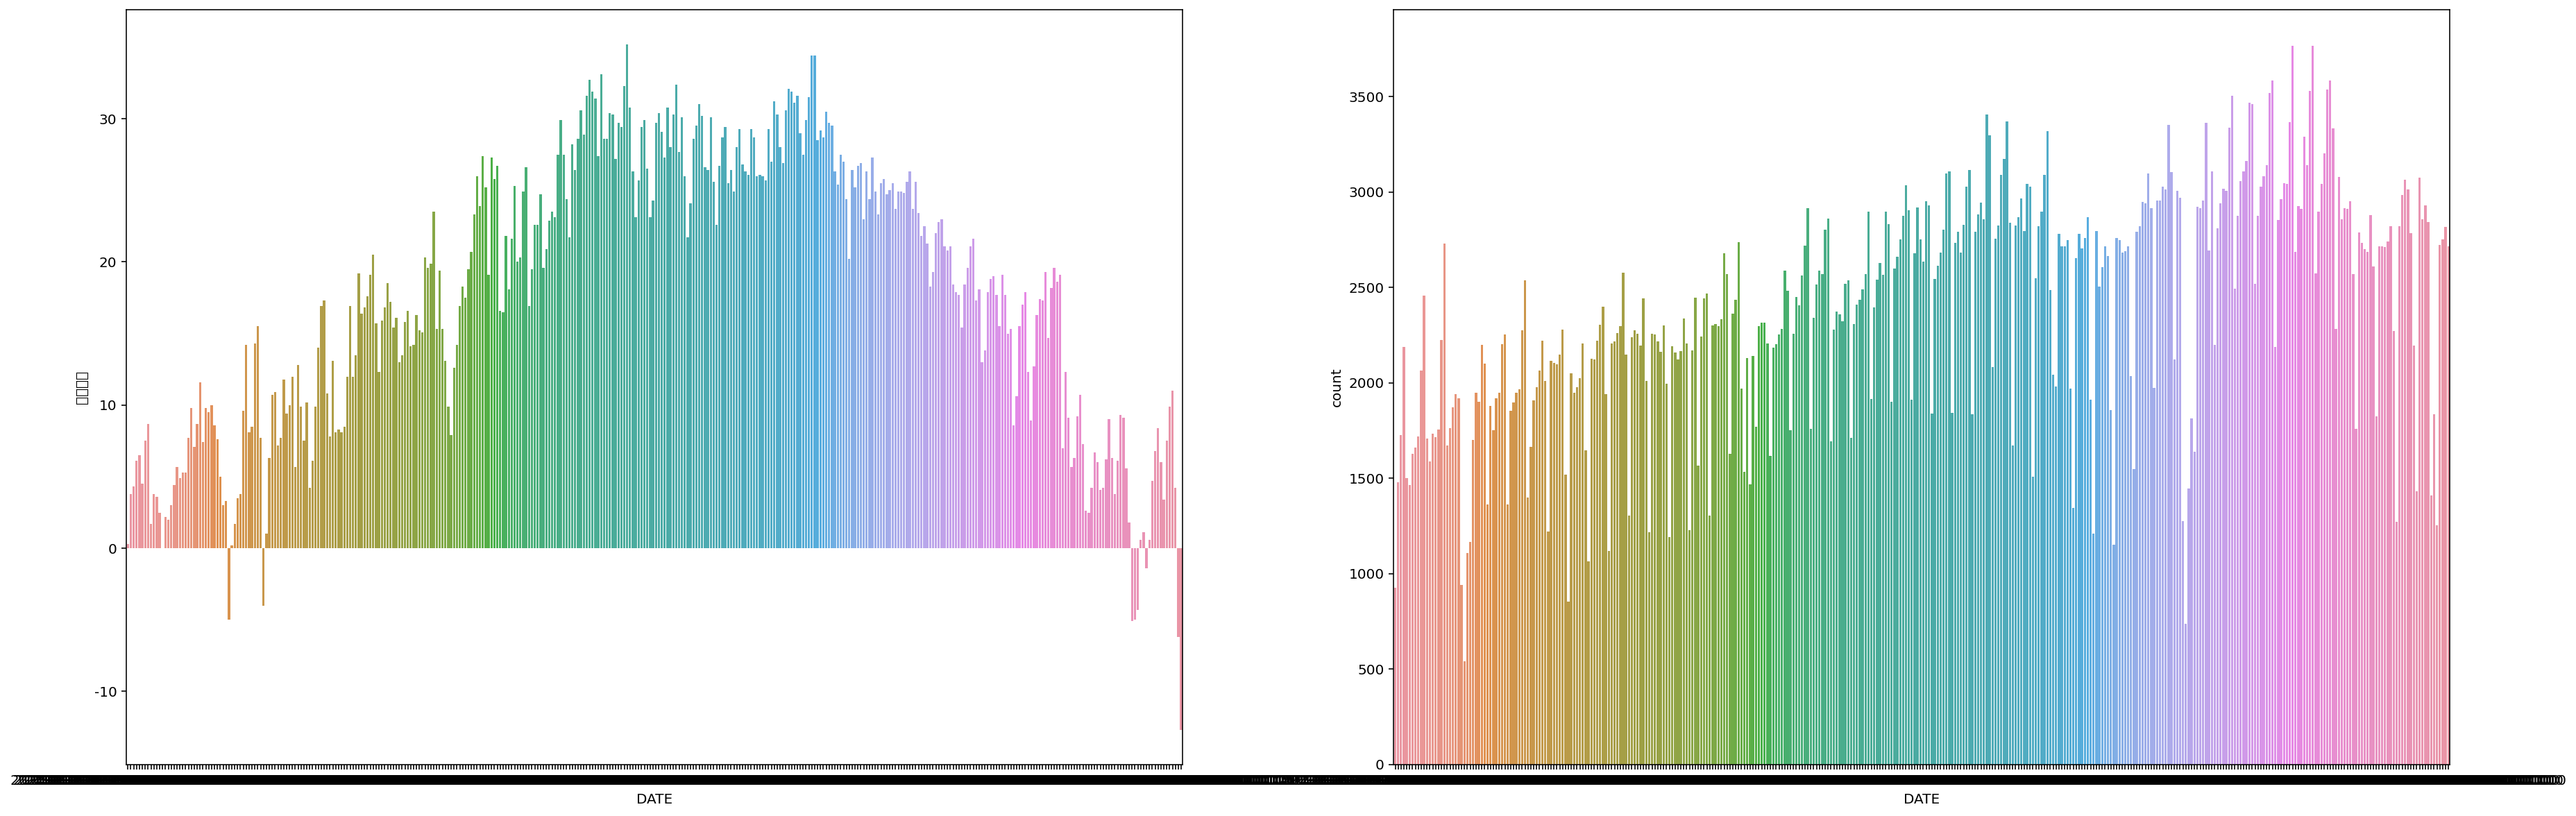

In [366]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(30,10)
sns.barplot(data=dailyweather_df3, x='DATE', y='최고기온', ax=ax1)
sns.countplot(data=df, x='DATE', ax=ax2)

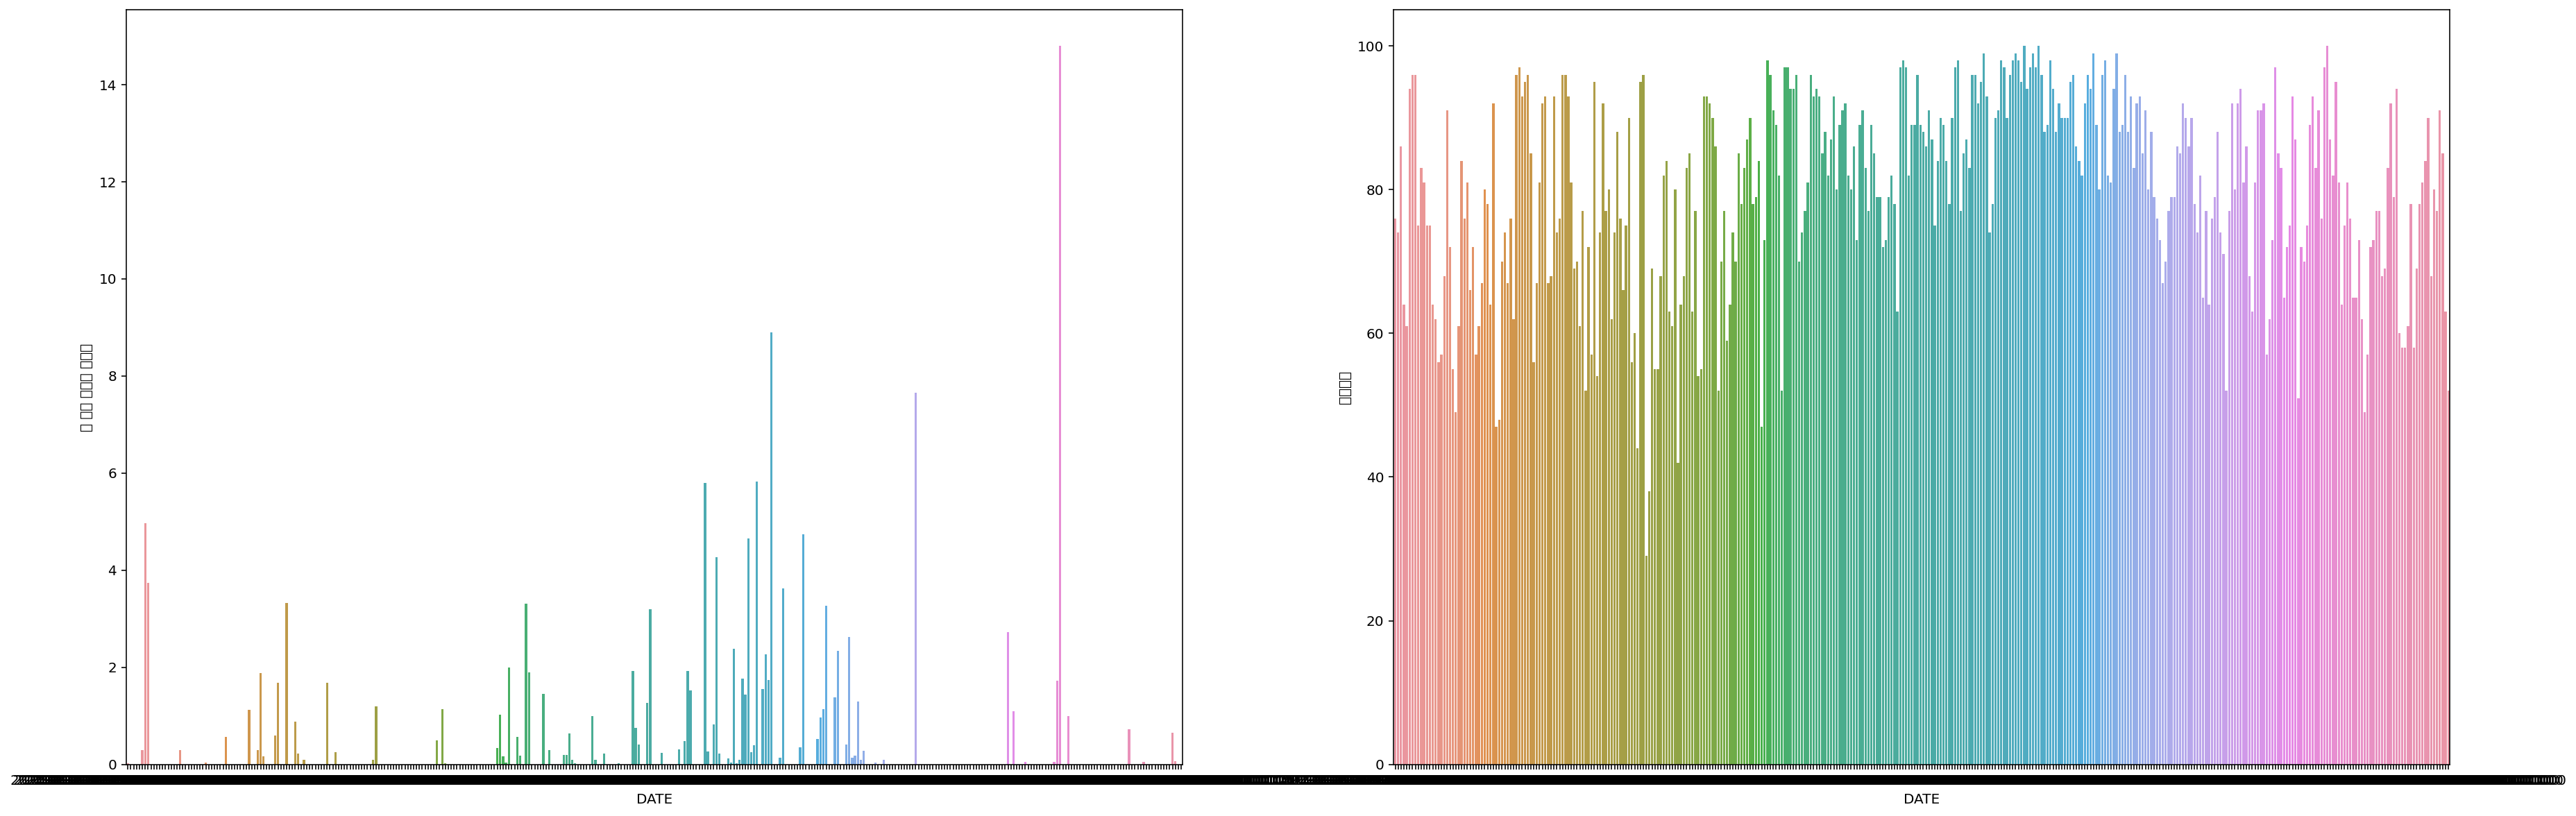

In [367]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(30,10)
sns.barplot(data=dailyweather_df3, x='DATE', y='일 평균 시간당 강수량', ax=ax1)
sns.barplot(data=dailyweather_df3, x='DATE', y='최고습도', ax=ax2)

### 교통량 데이터

In [368]:
traffic.head()

,DATE,지점명,지점번호,방향,구분,0시,1시,2시,3시,4시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,712.0,645.0,437.0,309.0,290.0,...,1472.0,1416.0,1483.0,1329.0,1157.0,1014.0,954.0,849.0,780.0,480.0
1,2020-01-02,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,315.0,222.0,186.0,165.0,266.0,...,1792.0,1897.0,1842.0,2061.0,1994.0,1443.0,1233.0,1165.0,1094.0,852.0
2,2020-01-03,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,632.0,457.0,295.0,236.0,279.0,...,2004.0,1929.0,2049.0,2140.0,2178.0,1654.0,1356.0,1260.0,1253.0,941.0
3,2020-01-04,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,740.0,518.0,388.0,331.0,330.0,...,1837.0,1788.0,1588.0,1669.0,1530.0,1222.0,1143.0,1089.0,1039.0,791.0
4,2020-01-05,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,533.0,424.0,297.0,230.0,209.0,...,1634.0,1673.0,1494.0,1429.0,1288.0,1035.0,987.0,884.0,803.0,564.0


In [369]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98820 entries, 0 to 98819
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    98820 non-null  datetime64[ns]
 1   지점명     98820 non-null  object        
 2   지점번호    98820 non-null  object        
 3   방향      98820 non-null  object        
 4   구분      98820 non-null  object        
 5   0시      91985 non-null  float64       
 6   1시      91962 non-null  float64       
 7   2시      91960 non-null  float64       
 8   3시      91979 non-null  float64       
 9   4시      91999 non-null  float64       
 10  5시      92036 non-null  float64       
 11  6시      92079 non-null  float64       
 12  7시      92095 non-null  float64       
 13  8시      92081 non-null  float64       
 14  9시      92110 non-null  float64       
 15  10시     92144 non-null  float64       
 16  11시     92100 non-null  float64       
 17  12시     92067 non-null  float64       
 18  13시   

In [370]:
traffic.mean()

0시      738.555232
1시      529.370240
2시      395.721237
3시      334.523598
4시      414.291155
5시      834.110109
6시     1428.291456
7시     1802.420870
8시     1936.528719
9시     1941.244034
10시    1938.276676
11시    1934.119175
12시    1905.291136
13시    1967.721162
14시    1993.541210
15시    2016.848641
16시    2063.231722
17시    2084.878621
18시    1993.774096
19시    1806.331019
20시    1654.021262
21시    1578.728633
22시    1341.815713
23시    1004.166438
dtype: float64

교통량은 오전 8시부터 저녁 6시까지 많은 편

In [371]:
traffic.isnull().sum()
non_list = list(set(np.where(traffic.isnull())[0]))
non_traffic = traffic[traffic.index.isin(non_list)]
len(non_traffic.지점명.unique())
traffic.dropna(how='any')
traffic

,DATE,지점명,지점번호,방향,구분,0시,1시,2시,3시,4시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,712.0,645.0,437.0,309.0,290.0,...,1472.0,1416.0,1483.0,1329.0,1157.0,1014.0,954.0,849.0,780.0,480.0
1,2020-01-02,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,315.0,222.0,186.0,165.0,266.0,...,1792.0,1897.0,1842.0,2061.0,1994.0,1443.0,1233.0,1165.0,1094.0,852.0
2,2020-01-03,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,632.0,457.0,295.0,236.0,279.0,...,2004.0,1929.0,2049.0,2140.0,2178.0,1654.0,1356.0,1260.0,1253.0,941.0
3,2020-01-04,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,740.0,518.0,388.0,331.0,330.0,...,1837.0,1788.0,1588.0,1669.0,1530.0,1222.0,1143.0,1089.0,1039.0,791.0
4,2020-01-05,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,533.0,424.0,297.0,230.0,209.0,...,1634.0,1673.0,1494.0,1429.0,1288.0,1035.0,987.0,884.0,803.0,564.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98815,2020-12-27,서부간선도로,F-09,유출,목동교->신정교,1310.0,804.0,582.0,473.0,488.0,...,3026.0,2957.0,2799.0,2858.0,2805.0,3031.0,3173.0,2928.0,2278.0,1559.0
98816,2020-12-28,서부간선도로,F-09,유출,목동교->신정교,1030.0,614.0,501.0,565.0,1160.0,...,2925.0,2595.0,2705.0,2264.0,2272.0,2954.0,3081.0,3099.0,2521.0,1837.0
98817,2020-12-29,서부간선도로,F-09,유출,목동교->신정교,1294.0,833.0,582.0,597.0,900.0,...,2634.0,2851.0,2704.0,2163.0,2165.0,2738.0,3054.0,3078.0,2544.0,1952.0
98818,2020-12-30,서부간선도로,F-09,유출,목동교->신정교,1451.0,929.0,616.0,591.0,929.0,...,2901.0,2636.0,2175.0,2036.0,1969.0,2787.0,3058.0,2936.0,2730.0,2160.0


In [372]:
traffic['일 평균 교통량'] = traffic.loc[:, "0시":'23시'].mean(axis=1)
mean_traffic = traffic.groupby('DATE')['일 평균 교통량'].mean().reset_index()
mean_traffic

,DATE,일 평균 교통량
0,2020-01-01,1190.898206
1,2020-01-02,1512.705932
2,2020-01-03,1608.532497
3,2020-01-04,1476.214802
4,2020-01-05,1260.954808
...,...,...
361,2020-12-27,999.324239
362,2020-12-28,1484.316884
363,2020-12-29,1495.891649
364,2020-12-30,1480.773536


In [373]:
ex_df = pd.merge(dailyweather_df3, mean_traffic, how = 'outer', on='DATE')
ex_df

,DATE,최고기온,일 평균 시간당 강수량,최저기온,최고습도,일 평균 교통량
0,2020-01-01,0.3,0.025000,-5.9,76,1190.898206
1,2020-01-02,3.8,NaN,-0.7,74,1512.705932
2,2020-01-03,4.3,NaN,-3.3,86,1608.532497
3,2020-01-04,6.1,NaN,-2.7,64,1476.214802
4,2020-01-05,6.5,NaN,-3.1,61,1260.954808
...,...,...,...,...,...,...
361,2020-12-27,9.9,0.000000,1.4,77,999.324239
362,2020-12-28,11.0,0.650000,4.3,91,1484.316884
363,2020-12-29,4.2,0.066667,-5.5,85,1495.891649
364,2020-12-30,-6.2,NaN,-12.9,63,1480.773536


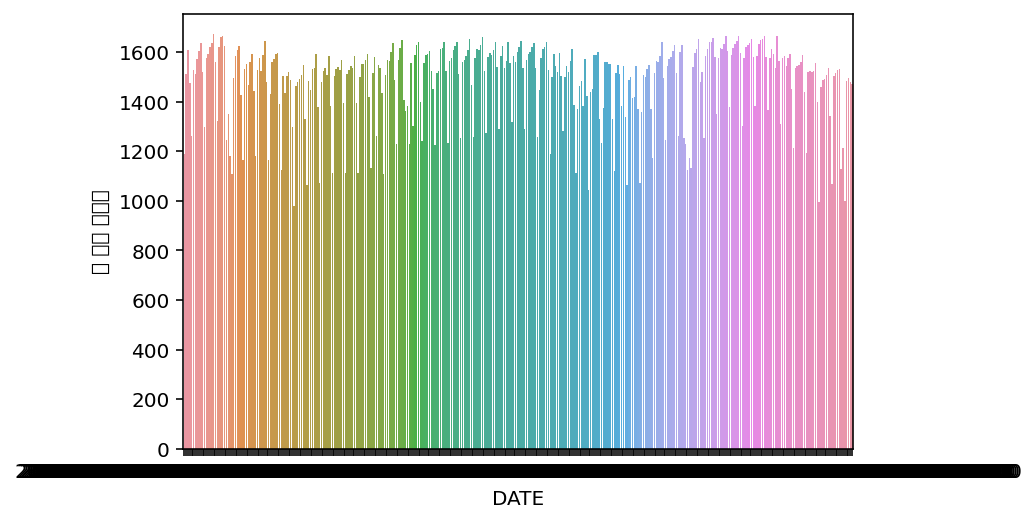

In [374]:
sns.barplot(data=ex_df,y='일 평균 교통량', x= 'DATE')

In [375]:
ex_df

,DATE,최고기온,일 평균 시간당 강수량,최저기온,최고습도,일 평균 교통량
0,2020-01-01,0.3,0.025000,-5.9,76,1190.898206
1,2020-01-02,3.8,NaN,-0.7,74,1512.705932
2,2020-01-03,4.3,NaN,-3.3,86,1608.532497
3,2020-01-04,6.1,NaN,-2.7,64,1476.214802
4,2020-01-05,6.5,NaN,-3.1,61,1260.954808
...,...,...,...,...,...,...
361,2020-12-27,9.9,0.000000,1.4,77,999.324239
362,2020-12-28,11.0,0.650000,4.3,91,1484.316884
363,2020-12-29,4.2,0.066667,-5.5,85,1495.891649
364,2020-12-30,-6.2,NaN,-12.9,63,1480.773536


In [376]:
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week,is_weekend,is_holiday,DAY
729776,999665,2018-12-16,CC,96266,A,2020-11-07,61,GN,5,11,45,1,0,5
748372,999665,2018-12-16,CC,109677,A,2020-11-13,59,JRR,4,11,46,0,0,4
751974,999665,2018-12-16,CC,1109,A,2020-11-14,58,JRR,5,11,46,1,0,5
726277,999665,2018-12-16,CC,190055,A,2020-11-06,55,SB,4,11,45,0,0,4
767392,999665,2018-12-16,CC,131081,A,2020-11-19,53,YO,3,11,47,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295494,1579165,2020-05-26,AA,27996,A,2020-05-27,1,J,2,5,22,0,0,2
295495,1579168,2020-05-26,AA,104916,A,2020-05-27,1,GN,2,5,22,0,0,2
295496,1579173,2020-05-26,AA,93362,A,2020-05-27,1,CY,2,5,22,0,0,2
295497,1579174,2020-05-26,BB,221017,A,2020-05-27,1,YD,2,5,22,0,0,2


### 데이터 통합

In [455]:
data = pd.merge(df, ex_df, how='outer', on='DATE')
data = data.sort_values(['COUNT'], ascending=False)
data.rename(columns={"DATE":'날짜'}, inplace=True)
data = data.fillna(0)
data = data[['날짜','USER_ID','GRADE', 'AD1','STORE_ID', 'GOODS_TYPE', '최고기온','일 평균 시간당 강수량', '최고습도', '일 평균 교통량','COUNT_SUM', 'COUNT']]

In [457]:
data

,날짜,USER_ID,GRADE,AD1,STORE_ID,GOODS_TYPE,최고기온,일 평균 시간당 강수량,최고습도,일 평균 교통량,COUNT_SUM,COUNT
0,2020-11-07,999665,mvp,GN,96266,A,17.9,0.05,93,1581.016477,7919,61
3765,2020-11-13,999665,mvp,JRR,109677,A,17.3,0.00,89,1666.509256,7919,59
7294,2020-11-14,999665,mvp,JRR,1109,A,19.3,0.00,93,1580.947900,7919,58
11059,2020-11-06,999665,mvp,SB,190055,A,17.0,0.00,75,1654.971858,7919,55
14425,2020-11-19,999665,mvp,YO,131081,A,19.1,14.80,100,1535.027552,7919,53
...,...,...,...,...,...,...,...,...,...,...,...,...
295907,2020-10-21,1554852,silver,JRR,82400,B,17.3,0.00,81,1614.549383,3,1
295908,2020-10-21,1555178,gold,J,220893,B,17.3,0.00,81,1614.549383,12,1
295909,2020-10-21,1555305,gold,GN,221045,A,17.3,0.00,81,1614.549383,14,1
295910,2020-10-21,1555428,mvp,J,92505,A,17.3,0.00,81,1614.549383,146,1


In [ ]:
df[df['D_TYPE']==2].count()
df[df['is_weekend']==1].count()
df.query('GOODS_TYPE == 0 and is_weekend == 0') # 443327
df.query('GOODS_TYPE == 1 and is_weekend == 0') # 109883
df.query('GOODS_TYPE == 2 and is_weekend == 0') # 90606
df.query('GOODS_TYPE == 3 and is_weekend == 0') # 90606

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week
874317,999665,2018-12-16,2,220797,3,2020-12-30,40,43,364,1605,2,0,0,12,53
424410,999665,2018-12-16,2,220578,3,2020-07-17,29,40,198,1605,4,0,0,7,29
701903,999665,2018-12-16,2,1109,3,2020-10-29,29,52,302,1605,3,0,0,10,44
480972,999665,2018-12-16,2,220797,3,2020-08-06,26,43,218,1605,3,0,0,8,32
493874,999665,2018-12-16,2,183093,3,2020-08-11,25,43,223,1605,1,0,0,8,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295548,1579656,2020-05-27,0,183093,3,2020-05-27,1,43,147,2133,2,0,0,5,22
295435,1575054,2020-05-22,1,91853,3,2020-05-27,1,81,147,2128,2,0,0,5,22
295512,1579385,2020-05-27,1,222357,3,2020-05-27,1,64,147,2133,2,0,0,5,22
295518,1579404,2020-05-27,0,220557,3,2020-05-27,1,82,147,2133,2,0,0,5,22


## 데이터 모델링

### 라이브러리 임포트

In [471]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


### 데이터 전처리

서울지역만 추려내서 분류

In [458]:
data['AD1'].unique()

array(['GN', 'JRR', 'SB', 'YO', 'MP', 'CY', 'DY', 'NO', 'J', 'SC', 'GS',
       'DM', 'SJV', 'YD', 'SD', 'GJ', 'BF', 'R', 'YC', 'GW', 'DJ', 'GPJ',
       'Q', 'GSN', 'ZE', 'CD', 'SOD', 'GD', 'GGY', 'BOI', 'P', '0', 'GAY',
       'GBC', 'GB', 'JR', 'GEJ', 'GHN', 'BO', 'BJG', 'DB', 'GSW', 'BP',
       'WT', 'BUD', 'WF', 'SG', 'PJP', 'RRR', 'CAS', 'GGM', 'IND', 'GYI',
       'BHW', 'IYS', 'CCA', 'CU', 'ABP', 'GAS', 'QH', 'CN', 'BI', 'GKP',
       'COI', 'DIV', 'SDU', 'QGI', 'SOI', 'AOI', 'VO', 'DSO', 'DOI', 'ZP',
       'VU', 'EP', 'SP', 'WAE', 'WH', 'GGC', 'WOID', 'CVB', 'X', 'ADS',
       'NW', 'GR'], dtype=object)

- 서울 지역구

종로구 : JR
중구 : J
용산구 : YO
성동구 : SOD
광진구 : GJ
동대문구 : DM
중랑구 : JRR
성북구 : SB
강북구 : GB
도봉구 : DB
노원구 : NW
은평구 : EP
서대문구 : SD
마포구 : MP
양천구 : YC
강서구 : GS
구로구 : GR
금천구 : GHN
영등포구 : YD
동작구 : DJ
관악구 : GW
서초구 : SC
강남구 : GN
송파구 : SP
강동구 : GD

In [459]:
seoul = ['JR','J','YO','SOD','GJ','DM','JRR','SB','GB','DB','NW','EP','SD','MP','YC','GS','GR','GHN','YD','DJ','GW','SC','GN','SP','GD']

In [460]:
seoul_list = []

for g in data['AD1']:
    if g in seoul:
        seoul_list.append('SEOUL')
    else:
        seoul_list.append('!SEOUL')

data['SEOUL'] = seoul_list

In [461]:
notseoul = data.loc[data['SEOUL']=='!SEOUL']
notseoul

,날짜,USER_ID,GRADE,AD1,STORE_ID,GOODS_TYPE,최고기온,일 평균 시간당 강수량,최고습도,일 평균 교통량,COUNT_SUM,COUNT,SEOUL
25009,2020-10-25,999665,mvp,CY,222401,A,17.9,0.000000,81,1380.744407,7919,50,!SEOUL
34250,2020-08-15,999665,mvp,CY,2428,A,26.9,3.631579,98,1330.054582,7919,49,!SEOUL
36737,2020-10-08,999665,mvp,DY,157711,A,22.8,0.000000,77,1651.610652,7919,48,!SEOUL
45885,2020-11-28,999665,mvp,CY,109670,A,2.6,0.000000,65,1452.777917,7919,46,!SEOUL
48456,2020-11-05,999665,mvp,NO,105202,A,15.5,0.000000,72,1639.180498,7919,46,!SEOUL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295917,2020-10-21,1557763,vvip,GBC,220788,A,17.3,0.000000,81,1614.549383,78,1,!SEOUL
295912,2020-10-21,1556329,gold,CAS,220744,D,17.3,0.000000,81,1614.549383,8,1,!SEOUL
295889,2020-10-21,1662900,vip,CY,82433,A,17.3,0.000000,81,1614.549383,28,1,!SEOUL
295905,2020-10-21,1612337,vip,0,172827,A,17.3,0.000000,81,1614.549383,23,1,!SEOUL


In [462]:
data = data.loc[data['SEOUL']=='SEOUL']
data

,날짜,USER_ID,GRADE,AD1,STORE_ID,GOODS_TYPE,최고기온,일 평균 시간당 강수량,최고습도,일 평균 교통량,COUNT_SUM,COUNT,SEOUL
0,2020-11-07,999665,mvp,GN,96266,A,17.9,0.05,93,1581.016477,7919,61,SEOUL
3765,2020-11-13,999665,mvp,JRR,109677,A,17.3,0.00,89,1666.509256,7919,59,SEOUL
7294,2020-11-14,999665,mvp,JRR,1109,A,19.3,0.00,93,1580.947900,7919,58,SEOUL
11059,2020-11-06,999665,mvp,SB,190055,A,17.0,0.00,75,1654.971858,7919,55,SEOUL
14425,2020-11-19,999665,mvp,YO,131081,A,19.1,14.80,100,1535.027552,7919,53,SEOUL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295906,2020-10-21,1554739,vvip,GS,222221,A,17.3,0.00,81,1614.549383,64,1,SEOUL
295907,2020-10-21,1554852,silver,JRR,82400,B,17.3,0.00,81,1614.549383,3,1,SEOUL
295908,2020-10-21,1555178,gold,J,220893,B,17.3,0.00,81,1614.549383,12,1,SEOUL
295909,2020-10-21,1555305,gold,GN,221045,A,17.3,0.00,81,1614.549383,14,1,SEOUL


In [463]:

# 범주형 데이터 One_hot_encoding
data = pd.get_dummies(data, columns=['GRADE','AD1','GOODS_TYPE'])

In [464]:
data = data.drop(['SEOUL'], axis=1)
data

,날짜,USER_ID,STORE_ID,최고기온,일 평균 시간당 강수량,최고습도,일 평균 교통량,COUNT_SUM,COUNT,GRADE_gold,...,AD1_SD,AD1_SOD,AD1_SP,AD1_YC,AD1_YD,AD1_YO,GOODS_TYPE_A,GOODS_TYPE_B,GOODS_TYPE_C,GOODS_TYPE_D
0,2020-11-07,999665,96266,17.9,0.05,93,1581.016477,7919,61,0,...,0,0,0,0,0,0,1,0,0,0
3765,2020-11-13,999665,109677,17.3,0.00,89,1666.509256,7919,59,0,...,0,0,0,0,0,0,1,0,0,0
7294,2020-11-14,999665,1109,19.3,0.00,93,1580.947900,7919,58,0,...,0,0,0,0,0,0,1,0,0,0
11059,2020-11-06,999665,190055,17.0,0.00,75,1654.971858,7919,55,0,...,0,0,0,0,0,0,1,0,0,0
14425,2020-11-19,999665,131081,19.1,14.80,100,1535.027552,7919,53,0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295906,2020-10-21,1554739,222221,17.3,0.00,81,1614.549383,64,1,0,...,0,0,0,0,0,0,1,0,0,0
295907,2020-10-21,1554852,82400,17.3,0.00,81,1614.549383,3,1,0,...,0,0,0,0,0,0,0,1,0,0
295908,2020-10-21,1555178,220893,17.3,0.00,81,1614.549383,12,1,1,...,0,0,0,0,0,0,0,1,0,0
295909,2020-10-21,1555305,221045,17.3,0.00,81,1614.549383,14,1,1,...,0,0,0,0,0,0,1,0,0,0


In [465]:
#training set & test set 분류

# training data set(2020-01~2020-09), test data set(2020-10~2020-12)
train = data[data['날짜'] <= '2020-09-30']
test = data[data['날짜'] > '2020-09-30']
display(train, test)

,날짜,USER_ID,STORE_ID,최고기온,일 평균 시간당 강수량,최고습도,일 평균 교통량,COUNT_SUM,COUNT,GRADE_gold,...,AD1_SD,AD1_SOD,AD1_SP,AD1_YC,AD1_YD,AD1_YO,GOODS_TYPE_A,GOODS_TYPE_B,GOODS_TYPE_C,GOODS_TYPE_D
90644,2020-09-19,999665,90542,25.8,0.1,88,1495.684009,7919,39,0,...,0,0,0,0,0,0,1,0,0,0
87739,2020-06-27,999665,2058,29.4,0.0,82,1556.576350,7919,39,0,...,0,0,0,0,0,0,1,0,0,0
102688,2020-09-26,999665,220959,24.8,0.0,79,1516.472743,7919,38,0,...,0,0,0,0,0,0,1,0,0,0
105793,2020-09-25,999665,83199,24.9,0.0,77,1631.030858,7919,37,0,...,0,0,0,0,0,0,0,0,1,0
120609,2020-07-11,999665,182175,30.1,0.0,78,1537.201242,7919,36,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295000,2020-09-21,1528475,220897,25.0,0.0,76,1543.107728,29,1,0,...,0,0,0,0,0,0,1,0,0,0
295001,2020-09-21,1531507,220959,25.0,0.0,76,1543.107728,97,1,0,...,0,0,0,0,0,0,1,0,0,0
295002,2020-09-21,1528273,228946,25.0,0.0,76,1543.107728,5,1,1,...,0,0,0,0,0,0,1,0,0,0
295003,2020-09-21,1528098,158176,25.0,0.0,76,1543.107728,151,1,0,...,0,0,0,0,0,0,1,0,0,0


,날짜,USER_ID,STORE_ID,최고기온,일 평균 시간당 강수량,최고습도,일 평균 교통량,COUNT_SUM,COUNT,GRADE_gold,...,AD1_SD,AD1_SOD,AD1_SP,AD1_YC,AD1_YD,AD1_YO,GOODS_TYPE_A,GOODS_TYPE_B,GOODS_TYPE_C,GOODS_TYPE_D
0,2020-11-07,999665,96266,17.9,0.05,93,1581.016477,7919,61,0,...,0,0,0,0,0,0,1,0,0,0
3765,2020-11-13,999665,109677,17.3,0.00,89,1666.509256,7919,59,0,...,0,0,0,0,0,0,1,0,0,0
7294,2020-11-14,999665,1109,19.3,0.00,93,1580.947900,7919,58,0,...,0,0,0,0,0,0,1,0,0,0
11059,2020-11-06,999665,190055,17.0,0.00,75,1654.971858,7919,55,0,...,0,0,0,0,0,0,1,0,0,0
14425,2020-11-19,999665,131081,19.1,14.80,100,1535.027552,7919,53,0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295906,2020-10-21,1554739,222221,17.3,0.00,81,1614.549383,64,1,0,...,0,0,0,0,0,0,1,0,0,0
295907,2020-10-21,1554852,82400,17.3,0.00,81,1614.549383,3,1,0,...,0,0,0,0,0,0,0,1,0,0
295908,2020-10-21,1555178,220893,17.3,0.00,81,1614.549383,12,1,1,...,0,0,0,0,0,0,0,1,0,0
295909,2020-10-21,1555305,221045,17.3,0.00,81,1614.549383,14,1,1,...,0,0,0,0,0,0,1,0,0,0


In [476]:
train = train[['날짜', 'USER_ID', 'STORE_ID', '최고기온', '일 평균 시간당 강수량', '최고습도', '일 평균 교통량',
       'COUNT_SUM', 'GRADE_gold', 'GRADE_mvp', 'GRADE_new',
       'GRADE_silver', 'GRADE_vip', 'GRADE_vvip', 'AD1_DB', 'AD1_DJ', 'AD1_DM',
       'AD1_EP', 'AD1_GB', 'AD1_GD', 'AD1_GHN', 'AD1_GJ', 'AD1_GN', 'AD1_GR',
       'AD1_GS', 'AD1_GW', 'AD1_J', 'AD1_JR', 'AD1_JRR', 'AD1_MP', 'AD1_NW',
       'AD1_SB', 'AD1_SC', 'AD1_SD', 'AD1_SOD', 'AD1_SP', 'AD1_YC', 'AD1_YD',
       'AD1_YO', 'GOODS_TYPE_A', 'GOODS_TYPE_B', 'GOODS_TYPE_C',
       'GOODS_TYPE_D','COUNT']]
test = test[['날짜', 'USER_ID', 'STORE_ID', '최고기온', '일 평균 시간당 강수량', '최고습도', '일 평균 교통량',
       'COUNT_SUM', 'GRADE_gold', 'GRADE_mvp', 'GRADE_new',
       'GRADE_silver', 'GRADE_vip', 'GRADE_vvip', 'AD1_DB', 'AD1_DJ', 'AD1_DM',
       'AD1_EP', 'AD1_GB', 'AD1_GD', 'AD1_GHN', 'AD1_GJ', 'AD1_GN', 'AD1_GR',
       'AD1_GS', 'AD1_GW', 'AD1_J', 'AD1_JR', 'AD1_JRR', 'AD1_MP', 'AD1_NW',
       'AD1_SB', 'AD1_SC', 'AD1_SD', 'AD1_SOD', 'AD1_SP', 'AD1_YC', 'AD1_YD',
       'AD1_YO', 'GOODS_TYPE_A', 'GOODS_TYPE_B', 'GOODS_TYPE_C',
       'GOODS_TYPE_D','COUNT']]

In [477]:
print(train.shape, test.shape)

(566387, 44) (232371, 44)


In [478]:

x_train = train.iloc[0:566133, 2:43].values
y_train = train.iloc[0:566133, [-1]].values

x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
print(x_train.shape, y_train.shape)

x_test = test.iloc[0:232371, 2:43].values
y_test = test.iloc[0:232371, [-1]].values

x_test = np.array(x_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)
print(x_test.shape, y_test.shape)

(566133, 41) (566133, 1)
(232371, 41) (232371, 1)


In [479]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [480]:
# 각 모델별 MSE 값 확인 (디폴트 설정)
np.random.seed(42)

gboost = GradientBoostingRegressor()
xgboost = XGBRegressor()
lightgbm = LGBMRegressor()
rdforest = RandomForestRegressor()
catboost = CatBoostRegressor()
models = [gboost, xgboost, lightgbm, rdforest, catboost]

In [481]:
def performance(models1, x_train, y_train, x_test):
    df2 = {}

    for model in models:      
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        print("사용한 모델 :",model)
        print("MSE :",mean_squared_error(y_test, y_pred))
        print("MAE :",mean_absolute_error(y_test, y_pred))
        print()
        print()

In [482]:
performance(models, x_train, y_train, x_test)

사용한 모델 : GradientBoostingRegressor()
MSE : 0.18923049020366856
MAE : 0.04648014511948102


사용한 모델 : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=24, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
MSE : 0.19936836
MAE : 0.050933696


사용한 모델 : LGBMRegressor()
MSE : 0.18679522456474615
MAE : 0.046880784888781425


사용한 모델 : RandomForestRegressor()
MSE : 0.20053253805655666
MAE : 0.06598761714655466


Learning rate set to 0.12062
0:	learn: 0.3850730	total: 171ms	remaining: 2m 50s
1:	learn: 0.3556811	total: 196ms	remainin

144:	learn: 0.1790484	total: 3.77s	remaining: 22.2s
145:	learn: 0.1789873	total: 3.79s	remaining: 22.2s
146:	learn: 0.1789411	total: 3.81s	remaining: 22.1s
147:	learn: 0.1788335	total: 3.84s	remaining: 22.1s
148:	learn: 0.1787900	total: 3.86s	remaining: 22.1s
149:	learn: 0.1785985	total: 3.89s	remaining: 22s
150:	learn: 0.1785290	total: 3.91s	remaining: 22s
151:	learn: 0.1783856	total: 3.94s	remaining: 22s
152:	learn: 0.1783552	total: 3.96s	remaining: 21.9s
153:	learn: 0.1782349	total: 3.99s	remaining: 21.9s
154:	learn: 0.1781579	total: 4.01s	remaining: 21.9s
155:	learn: 0.1780597	total: 4.04s	remaining: 21.8s
156:	learn: 0.1779454	total: 4.06s	remaining: 21.8s
157:	learn: 0.1778544	total: 4.09s	remaining: 21.8s
158:	learn: 0.1778004	total: 4.11s	remaining: 21.7s
159:	learn: 0.1776443	total: 4.13s	remaining: 21.7s
160:	learn: 0.1775331	total: 4.16s	remaining: 21.7s
161:	learn: 0.1774968	total: 4.18s	remaining: 21.7s
162:	learn: 0.1774853	total: 4.21s	remaining: 21.6s
163:	learn: 0.1773

306:	learn: 0.1706592	total: 7.78s	remaining: 17.6s
307:	learn: 0.1706264	total: 7.8s	remaining: 17.5s
308:	learn: 0.1706118	total: 7.83s	remaining: 17.5s
309:	learn: 0.1705906	total: 7.85s	remaining: 17.5s
310:	learn: 0.1705707	total: 7.88s	remaining: 17.5s
311:	learn: 0.1705488	total: 7.9s	remaining: 17.4s
312:	learn: 0.1705326	total: 7.93s	remaining: 17.4s
313:	learn: 0.1705070	total: 7.95s	remaining: 17.4s
314:	learn: 0.1704866	total: 7.98s	remaining: 17.4s
315:	learn: 0.1704814	total: 8s	remaining: 17.3s
316:	learn: 0.1704370	total: 8.03s	remaining: 17.3s
317:	learn: 0.1704070	total: 8.05s	remaining: 17.3s
318:	learn: 0.1703912	total: 8.08s	remaining: 17.2s
319:	learn: 0.1703708	total: 8.1s	remaining: 17.2s
320:	learn: 0.1703447	total: 8.12s	remaining: 17.2s
321:	learn: 0.1703148	total: 8.15s	remaining: 17.2s
322:	learn: 0.1702998	total: 8.17s	remaining: 17.1s
323:	learn: 0.1702783	total: 8.2s	remaining: 17.1s
324:	learn: 0.1702559	total: 8.22s	remaining: 17.1s
325:	learn: 0.17024

471:	learn: 0.1672542	total: 11.9s	remaining: 13.3s
472:	learn: 0.1672535	total: 11.9s	remaining: 13.3s
473:	learn: 0.1672390	total: 11.9s	remaining: 13.2s
474:	learn: 0.1672367	total: 12s	remaining: 13.2s
475:	learn: 0.1672246	total: 12s	remaining: 13.2s
476:	learn: 0.1671934	total: 12s	remaining: 13.2s
477:	learn: 0.1671725	total: 12s	remaining: 13.1s
478:	learn: 0.1671595	total: 12.1s	remaining: 13.1s
479:	learn: 0.1671493	total: 12.1s	remaining: 13.1s
480:	learn: 0.1671435	total: 12.1s	remaining: 13.1s
481:	learn: 0.1671413	total: 12.1s	remaining: 13s
482:	learn: 0.1671369	total: 12.1s	remaining: 13s
483:	learn: 0.1671259	total: 12.2s	remaining: 13s
484:	learn: 0.1671175	total: 12.2s	remaining: 13s
485:	learn: 0.1670695	total: 12.2s	remaining: 12.9s
486:	learn: 0.1670574	total: 12.2s	remaining: 12.9s
487:	learn: 0.1670291	total: 12.3s	remaining: 12.9s
488:	learn: 0.1670208	total: 12.3s	remaining: 12.9s
489:	learn: 0.1670177	total: 12.3s	remaining: 12.8s
490:	learn: 0.1670055	total:

633:	learn: 0.1654223	total: 15.9s	remaining: 9.18s
634:	learn: 0.1654203	total: 15.9s	remaining: 9.16s
635:	learn: 0.1654096	total: 16s	remaining: 9.13s
636:	learn: 0.1653979	total: 16s	remaining: 9.11s
637:	learn: 0.1653919	total: 16s	remaining: 9.09s
638:	learn: 0.1653865	total: 16s	remaining: 9.06s
639:	learn: 0.1653755	total: 16.1s	remaining: 9.04s
640:	learn: 0.1653714	total: 16.1s	remaining: 9.01s
641:	learn: 0.1653640	total: 16.1s	remaining: 8.99s
642:	learn: 0.1653626	total: 16.1s	remaining: 8.96s
643:	learn: 0.1653556	total: 16.2s	remaining: 8.94s
644:	learn: 0.1653535	total: 16.2s	remaining: 8.91s
645:	learn: 0.1653347	total: 16.2s	remaining: 8.89s
646:	learn: 0.1653284	total: 16.2s	remaining: 8.86s
647:	learn: 0.1653221	total: 16.3s	remaining: 8.84s
648:	learn: 0.1653136	total: 16.3s	remaining: 8.81s
649:	learn: 0.1653077	total: 16.3s	remaining: 8.79s
650:	learn: 0.1653065	total: 16.3s	remaining: 8.76s
651:	learn: 0.1653022	total: 16.4s	remaining: 8.73s
652:	learn: 0.165295

792:	learn: 0.1643122	total: 20s	remaining: 5.21s
793:	learn: 0.1643086	total: 20s	remaining: 5.19s
794:	learn: 0.1643034	total: 20s	remaining: 5.16s
795:	learn: 0.1643027	total: 20s	remaining: 5.14s
796:	learn: 0.1642988	total: 20.1s	remaining: 5.11s
797:	learn: 0.1642975	total: 20.1s	remaining: 5.09s
798:	learn: 0.1642958	total: 20.1s	remaining: 5.06s
799:	learn: 0.1642934	total: 20.1s	remaining: 5.04s
800:	learn: 0.1642917	total: 20.2s	remaining: 5.01s
801:	learn: 0.1642889	total: 20.2s	remaining: 4.99s
802:	learn: 0.1642811	total: 20.2s	remaining: 4.96s
803:	learn: 0.1642800	total: 20.2s	remaining: 4.93s
804:	learn: 0.1642777	total: 20.3s	remaining: 4.91s
805:	learn: 0.1642756	total: 20.3s	remaining: 4.89s
806:	learn: 0.1642737	total: 20.3s	remaining: 4.86s
807:	learn: 0.1642709	total: 20.4s	remaining: 4.84s
808:	learn: 0.1642669	total: 20.4s	remaining: 4.81s
809:	learn: 0.1642636	total: 20.4s	remaining: 4.79s
810:	learn: 0.1642612	total: 20.4s	remaining: 4.76s
811:	learn: 0.164257

951:	learn: 0.1636001	total: 24.2s	remaining: 1.22s
952:	learn: 0.1635985	total: 24.2s	remaining: 1.19s
953:	learn: 0.1635972	total: 24.2s	remaining: 1.17s
954:	learn: 0.1635914	total: 24.2s	remaining: 1.14s
955:	learn: 0.1635877	total: 24.3s	remaining: 1.12s
956:	learn: 0.1635857	total: 24.3s	remaining: 1.09s
957:	learn: 0.1635814	total: 24.3s	remaining: 1.06s
958:	learn: 0.1635805	total: 24.3s	remaining: 1.04s
959:	learn: 0.1635787	total: 24.4s	remaining: 1.01s
960:	learn: 0.1635748	total: 24.4s	remaining: 990ms
961:	learn: 0.1635729	total: 24.4s	remaining: 965ms
962:	learn: 0.1635683	total: 24.5s	remaining: 940ms
963:	learn: 0.1635665	total: 24.5s	remaining: 914ms
964:	learn: 0.1635513	total: 24.5s	remaining: 889ms
965:	learn: 0.1635463	total: 24.5s	remaining: 863ms
966:	learn: 0.1635459	total: 24.6s	remaining: 838ms
967:	learn: 0.1635425	total: 24.6s	remaining: 813ms
968:	learn: 0.1635399	total: 24.6s	remaining: 787ms
969:	learn: 0.1635385	total: 24.6s	remaining: 762ms
970:	learn: 

In [485]:
# GradientBoostingRegressor 모델의 MSE, MAE값이 가장 낮음
# 모델의 가장 좋은 파라미터 찾기

# 파라미터 범위
param_grid = {
    'loss': ['huber'],
    'n_estimators': [100],
    'learning_rate' : [0.1],
    'criterion' : ['friedman_mse'],
    'max_depth' : [30]
}

# 모델 준비 (GradientBoostingRegressor)
model1 = GradientBoostingRegressor()

In [486]:
model1.get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [487]:
# GridSearch로 가장 좋은 파라미터 찾기
GCV = GridSearchCV(model1, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=5)

# 모델 fitting
GCV.fit(x_train, y_train)

# 가장 좋은 파라미터 찾기
print("Best Param :", GCV.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   10.0s remaining:   15.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   10.0s finished


Best Param : {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 30, 'n_estimators': 100}


In [488]:
# 가장 좋은 파라미터로 모델 설정
model1=GCV.best_estimator_ 

# 예측
y_pred1 = model1.predict(x_test)

In [489]:
# MSE, MAE값
print("MSE :",mean_squared_error(y_test, y_pred1))
print("MAE :",mean_absolute_error(y_test, y_pred1))

MSE : 0.4520658774115531
MAE : 0.03423404813853708
